In [18]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models, datasets, transforms
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict
from fastai import *
from fastai.vision.all import *
from fastai.callback.all import *
import torch.optim as optim
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### Checking if GPU is available

In [19]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have only one GPU
    print("GPU Compute Capability:", torch.cuda.get_device_capability(0))
    print("Number of GPUs:", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

GPU is available.
GPU Device Name: NVIDIA GeForce RTX 2060
GPU Compute Capability: (7, 5)
Number of GPUs: 1


### Data Processing - Loading, splitting and tranforming

In [20]:
# Define the classes (assuming you have a file with class names)
classes = open("C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/meta/classes.txt", 'r').read().splitlines()
num_classes = len(classes)

# Function to prepare the DataFrame
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    img_path = "C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)

    imgs = np.array(imgs)
    imgs = pd.DataFrame(imgs[:, 0], imgs[:, 1], columns=['label'])
    imgs['path'] = full_path

    imgs = shuffle(imgs)

    return imgs

# Prepare train and test DataFrames
train_imgs = prep_df("C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/meta/train.txt")
test_imgs = prep_df("C:/Users/rsk29/Documents/UT/Fall/AML/Final Project/food-101/meta/test.txt")

# Split the training data into train and validation sets (70-30 split)
train_data, val_data = train_test_split(train_imgs, test_size=0.3, random_state=42)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the label encoder class
class LabelEncoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = LabelEncoder(classes)

# Define the dataset class
class FoodLabelsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and loaders for train, validation, and test sets
train_dataset = FoodLabelsDataset(train_data, transform=transform)
val_dataset = FoodLabelsDataset(val_data, transform=transform)
test_dataset = FoodLabelsDataset(test_imgs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

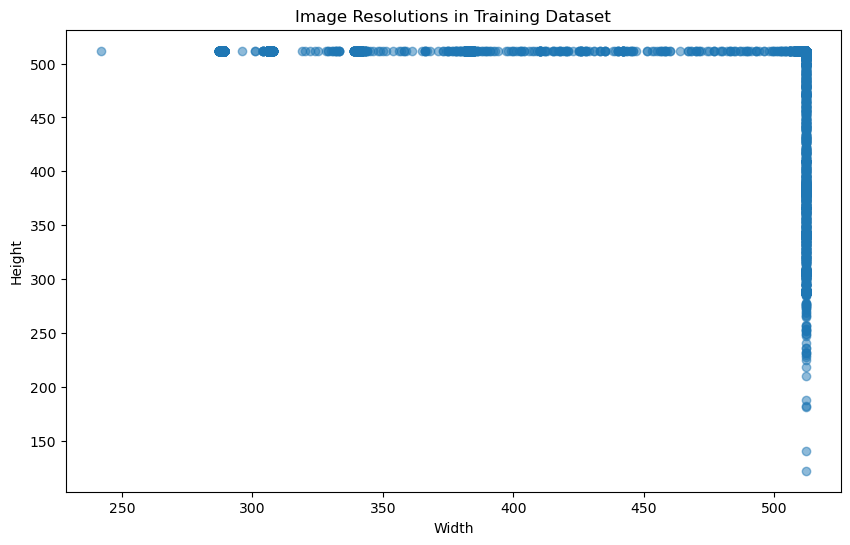

In [21]:
#Checking the spread of the image resolutionn in the training data

def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

train_resolutions = [get_image_resolution(img_path) for img_path in train_data['path']]

widths, heights = zip(*train_resolutions)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Resolutions in Training Dataset')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

The images are not of standard size in the actual training data - This is the reason for transforming them to a standard size of 224 x 224

### Modeling - Alexnet and Resnet34

In [23]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
columns = ['Epoch', 'Batch', 'Phase', 'Loss', 'Accuracy']
results_df = pd.DataFrame(columns=columns)

for epoch in range(num_epochs):
    for phase in ['Train', 'Validation']:
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        data_loader = train_loader if phase == 'Train' else val_loader

        model.train() if phase == 'Train' else model.eval()

        with torch.set_grad_enabled(phase == 'Train'):
            for i, data in enumerate(tqdm(data_loader, desc=f'{phase} Epoch {epoch + 1}/{num_epochs}', unit='batch')):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'Train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                if i % 10 == 9:  # Print every 100 mini-batches
                    avg_loss = running_loss / 10
                    accuracy = correct_predictions / total_samples * 100
                    print(f"[{epoch + 1}, {i + 1:5d}] {phase} loss: {avg_loss:.3f}, accuracy: {accuracy:.2f}%")

                    # Append results to the DataFrame
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'Epoch': epoch + 1,
                        'Batch': i + 1,
                        'Phase': phase,
                        'Loss': avg_loss,
                        'Accuracy': accuracy
                    }, index=[0])], ignore_index=True)
                    running_loss = 0.0
                    correct_predictions = 0
                    total_samples = 0

# Save the trained model with validation
torch.save(model.state_dict(), 'trained_model_with_validation.pth')
print("Model saved successfully")

# Save the training and validation results to a CSV file
results_df.to_csv('Resnet34 - Final Results.csv', index=False)


C:\Users\rsk29\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rsk29\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1/10:   2%|█▍                                                          | 10/415 [00:12<08:01,  1.19s/batch]

[1,    10] Train loss: 4.693, accuracy: 1.48%


Train Epoch 1/10:   5%|██▉                                                         | 20/415 [00:24<08:03,  1.22s/batch]

[1,    20] Train loss: 4.373, accuracy: 6.56%


Train Epoch 1/10:   7%|████▎                                                       | 30/415 [00:36<07:52,  1.23s/batch]

[1,    30] Train loss: 3.817, accuracy: 18.67%


Train Epoch 1/10:  10%|█████▊                                                      | 40/415 [00:49<07:57,  1.27s/batch]

[1,    40] Train loss: 3.369, accuracy: 26.33%


Train Epoch 1/10:  12%|███████▏                                                    | 50/415 [01:01<07:39,  1.26s/batch]

[1,    50] Train loss: 2.980, accuracy: 31.95%


Train Epoch 1/10:  14%|████████▋                                                   | 60/415 [01:14<07:40,  1.30s/batch]

[1,    60] Train loss: 2.618, accuracy: 38.28%


Train Epoch 1/10:  17%|██████████                                                  | 70/415 [01:27<07:39,  1.33s/batch]

[1,    70] Train loss: 2.325, accuracy: 44.14%


Train Epoch 1/10:  19%|███████████▌                                                | 80/415 [01:41<07:27,  1.34s/batch]

[1,    80] Train loss: 2.203, accuracy: 45.70%


Train Epoch 1/10:  22%|█████████████                                               | 90/415 [01:54<07:14,  1.34s/batch]

[1,    90] Train loss: 2.144, accuracy: 47.34%


Train Epoch 1/10:  24%|██████████████▏                                            | 100/415 [02:07<06:58,  1.33s/batch]

[1,   100] Train loss: 2.012, accuracy: 50.94%


Train Epoch 1/10:  27%|███████████████▋                                           | 110/415 [02:21<06:50,  1.35s/batch]

[1,   110] Train loss: 1.987, accuracy: 50.23%


Train Epoch 1/10:  29%|█████████████████                                          | 120/415 [02:34<06:37,  1.35s/batch]

[1,   120] Train loss: 1.962, accuracy: 50.94%


Train Epoch 1/10:  31%|██████████████████▍                                        | 130/415 [02:48<06:23,  1.34s/batch]

[1,   130] Train loss: 1.877, accuracy: 53.12%


Train Epoch 1/10:  34%|███████████████████▉                                       | 140/415 [03:01<06:18,  1.38s/batch]

[1,   140] Train loss: 1.820, accuracy: 56.02%


Train Epoch 1/10:  36%|█████████████████████▎                                     | 150/415 [03:15<06:01,  1.37s/batch]

[1,   150] Train loss: 1.804, accuracy: 54.53%


Train Epoch 1/10:  39%|██████████████████████▋                                    | 160/415 [03:29<05:55,  1.39s/batch]

[1,   160] Train loss: 1.677, accuracy: 56.80%


Train Epoch 1/10:  41%|████████████████████████▏                                  | 170/415 [03:43<05:41,  1.39s/batch]

[1,   170] Train loss: 1.721, accuracy: 56.88%


Train Epoch 1/10:  43%|█████████████████████████▌                                 | 180/415 [03:56<05:25,  1.38s/batch]

[1,   180] Train loss: 1.747, accuracy: 56.33%


Train Epoch 1/10:  46%|███████████████████████████                                | 190/415 [04:10<05:12,  1.39s/batch]

[1,   190] Train loss: 1.730, accuracy: 54.61%


Train Epoch 1/10:  48%|████████████████████████████▍                              | 200/415 [04:25<05:00,  1.40s/batch]

[1,   200] Train loss: 1.721, accuracy: 54.37%


Train Epoch 1/10:  51%|█████████████████████████████▊                             | 210/415 [04:39<04:46,  1.40s/batch]

[1,   210] Train loss: 1.618, accuracy: 57.81%


Train Epoch 1/10:  53%|███████████████████████████████▎                           | 220/415 [04:53<04:57,  1.52s/batch]

[1,   220] Train loss: 1.585, accuracy: 60.62%


Train Epoch 1/10:  55%|████████████████████████████████▋                          | 230/415 [05:09<04:36,  1.50s/batch]

[1,   230] Train loss: 1.600, accuracy: 57.89%


Train Epoch 1/10:  58%|██████████████████████████████████                         | 240/415 [05:23<04:18,  1.47s/batch]

[1,   240] Train loss: 1.561, accuracy: 60.16%


Train Epoch 1/10:  60%|███████████████████████████████████▌                       | 250/415 [05:38<04:01,  1.46s/batch]

[1,   250] Train loss: 1.599, accuracy: 59.45%


Train Epoch 1/10:  63%|████████████████████████████████████▉                      | 260/415 [05:54<04:00,  1.55s/batch]

[1,   260] Train loss: 1.588, accuracy: 60.47%


Train Epoch 1/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:09<03:49,  1.58s/batch]

[1,   270] Train loss: 1.474, accuracy: 60.94%


Train Epoch 1/10:  67%|███████████████████████████████████████▊                   | 280/415 [06:25<03:34,  1.59s/batch]

[1,   280] Train loss: 1.480, accuracy: 60.78%


Train Epoch 1/10:  70%|█████████████████████████████████████████▏                 | 290/415 [06:41<03:18,  1.59s/batch]

[1,   290] Train loss: 1.525, accuracy: 62.03%


Train Epoch 1/10:  72%|██████████████████████████████████████████▋                | 300/415 [06:57<03:03,  1.60s/batch]

[1,   300] Train loss: 1.482, accuracy: 62.19%


Train Epoch 1/10:  75%|████████████████████████████████████████████               | 310/415 [07:13<02:48,  1.61s/batch]

[1,   310] Train loss: 1.486, accuracy: 59.77%


Train Epoch 1/10:  77%|█████████████████████████████████████████████▍             | 320/415 [07:29<02:35,  1.64s/batch]

[1,   320] Train loss: 1.458, accuracy: 62.66%


Train Epoch 1/10:  80%|██████████████████████████████████████████████▉            | 330/415 [07:46<02:19,  1.64s/batch]

[1,   330] Train loss: 1.508, accuracy: 61.17%


Train Epoch 1/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:02<02:03,  1.65s/batch]

[1,   340] Train loss: 1.511, accuracy: 60.08%


Train Epoch 1/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:19<01:46,  1.64s/batch]

[1,   350] Train loss: 1.359, accuracy: 63.12%


Train Epoch 1/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:35<01:30,  1.64s/batch]

[1,   360] Train loss: 1.497, accuracy: 61.80%


Train Epoch 1/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [08:52<01:14,  1.64s/batch]

[1,   370] Train loss: 1.425, accuracy: 63.52%


Train Epoch 1/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:08<00:58,  1.66s/batch]

[1,   380] Train loss: 1.498, accuracy: 60.86%


Train Epoch 1/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:26<00:43,  1.73s/batch]

[1,   390] Train loss: 1.431, accuracy: 61.72%


Train Epoch 1/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:42<00:25,  1.68s/batch]

[1,   400] Train loss: 1.454, accuracy: 63.12%


Train Epoch 1/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [09:59<00:08,  1.64s/batch]

[1,   410] Train loss: 1.367, accuracy: 64.61%


Validation Epoch 1/10:   6%|███                                                    | 10/178 [00:12<03:29,  1.25s/batch]

[1,    10] Validation loss: 1.545, accuracy: 60.08%


Validation Epoch 1/10:  11%|██████▏                                                | 20/178 [00:24<03:19,  1.26s/batch]

[1,    20] Validation loss: 1.510, accuracy: 60.16%


Validation Epoch 1/10:  17%|█████████▎                                             | 30/178 [00:37<02:59,  1.21s/batch]

[1,    30] Validation loss: 1.540, accuracy: 60.23%


Validation Epoch 1/10:  22%|████████████▎                                          | 40/178 [00:49<02:44,  1.19s/batch]

[1,    40] Validation loss: 1.602, accuracy: 58.20%


Validation Epoch 1/10:  28%|███████████████▍                                       | 50/178 [01:01<02:34,  1.21s/batch]

[1,    50] Validation loss: 1.599, accuracy: 58.52%


Validation Epoch 1/10:  34%|██████████████████▌                                    | 60/178 [01:13<02:18,  1.17s/batch]

[1,    60] Validation loss: 1.584, accuracy: 58.44%


Validation Epoch 1/10:  39%|█████████████████████▋                                 | 70/178 [01:24<02:07,  1.18s/batch]

[1,    70] Validation loss: 1.668, accuracy: 56.95%


Validation Epoch 1/10:  45%|████████████████████████▋                              | 80/178 [01:36<02:00,  1.23s/batch]

[1,    80] Validation loss: 1.625, accuracy: 58.75%


Validation Epoch 1/10:  51%|███████████████████████████▊                           | 90/178 [01:49<01:46,  1.21s/batch]

[1,    90] Validation loss: 1.580, accuracy: 59.38%


Validation Epoch 1/10:  56%|██████████████████████████████▎                       | 100/178 [02:01<01:34,  1.21s/batch]

[1,   100] Validation loss: 1.626, accuracy: 58.05%


Validation Epoch 1/10:  62%|█████████████████████████████████▎                    | 110/178 [02:13<01:22,  1.22s/batch]

[1,   110] Validation loss: 1.605, accuracy: 58.75%


Validation Epoch 1/10:  67%|████████████████████████████████████▍                 | 120/178 [02:25<01:12,  1.25s/batch]

[1,   120] Validation loss: 1.693, accuracy: 54.84%


Validation Epoch 1/10:  73%|███████████████████████████████████████▍              | 130/178 [02:38<01:01,  1.28s/batch]

[1,   130] Validation loss: 1.550, accuracy: 58.83%


Validation Epoch 1/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:50<00:47,  1.25s/batch]

[1,   140] Validation loss: 1.550, accuracy: 59.84%


Validation Epoch 1/10:  84%|█████████████████████████████████████████████▌        | 150/178 [03:03<00:34,  1.23s/batch]

[1,   150] Validation loss: 1.494, accuracy: 59.30%


Validation Epoch 1/10:  90%|████████████████████████████████████████████████▌     | 160/178 [03:15<00:22,  1.27s/batch]

[1,   160] Validation loss: 1.552, accuracy: 59.69%


Validation Epoch 1/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:28<00:09,  1.24s/batch]

[1,   170] Validation loss: 1.661, accuracy: 57.34%


Train Epoch 2/10:   2%|█▍                                                          | 10/415 [00:16<11:21,  1.68s/batch]

[2,    10] Train loss: 1.135, accuracy: 70.16%


Train Epoch 2/10:   5%|██▉                                                         | 20/415 [00:33<11:17,  1.72s/batch]

[2,    20] Train loss: 1.024, accuracy: 73.12%


Train Epoch 2/10:   7%|████▎                                                       | 30/415 [00:50<10:51,  1.69s/batch]

[2,    30] Train loss: 0.980, accuracy: 73.20%


Train Epoch 2/10:  10%|█████▊                                                      | 40/415 [01:07<10:38,  1.70s/batch]

[2,    40] Train loss: 1.019, accuracy: 72.27%


Train Epoch 2/10:  12%|███████▏                                                    | 50/415 [01:24<10:09,  1.67s/batch]

[2,    50] Train loss: 0.968, accuracy: 72.73%


Train Epoch 2/10:  14%|████████▋                                                   | 60/415 [01:40<09:41,  1.64s/batch]

[2,    60] Train loss: 1.017, accuracy: 72.97%


Train Epoch 2/10:  17%|██████████                                                  | 70/415 [01:57<09:59,  1.74s/batch]

[2,    70] Train loss: 1.027, accuracy: 72.58%


Train Epoch 2/10:  19%|███████████▌                                                | 80/415 [02:16<10:56,  1.96s/batch]

[2,    80] Train loss: 1.016, accuracy: 72.58%


Train Epoch 2/10:  22%|█████████████                                               | 90/415 [02:33<09:30,  1.76s/batch]

[2,    90] Train loss: 1.018, accuracy: 72.27%


Train Epoch 2/10:  24%|██████████████▏                                            | 100/415 [02:51<08:39,  1.65s/batch]

[2,   100] Train loss: 0.978, accuracy: 73.75%


Train Epoch 2/10:  27%|███████████████▋                                           | 110/415 [03:08<08:54,  1.75s/batch]

[2,   110] Train loss: 0.977, accuracy: 72.73%


Train Epoch 2/10:  29%|█████████████████                                          | 120/415 [03:25<08:38,  1.76s/batch]

[2,   120] Train loss: 1.028, accuracy: 71.48%


Train Epoch 2/10:  31%|██████████████████▍                                        | 130/415 [03:42<08:03,  1.70s/batch]

[2,   130] Train loss: 1.028, accuracy: 71.95%


Train Epoch 2/10:  34%|███████████████████▉                                       | 140/415 [03:59<07:46,  1.70s/batch]

[2,   140] Train loss: 0.991, accuracy: 73.75%


Train Epoch 2/10:  36%|█████████████████████▎                                     | 150/415 [04:15<07:02,  1.59s/batch]

[2,   150] Train loss: 1.064, accuracy: 71.72%


Train Epoch 2/10:  39%|██████████████████████▋                                    | 160/415 [04:32<07:02,  1.66s/batch]

[2,   160] Train loss: 1.050, accuracy: 71.48%


Train Epoch 2/10:  41%|████████████████████████▏                                  | 170/415 [04:47<06:02,  1.48s/batch]

[2,   170] Train loss: 0.993, accuracy: 72.50%


Train Epoch 2/10:  43%|█████████████████████████▌                                 | 180/415 [05:02<05:50,  1.49s/batch]

[2,   180] Train loss: 1.091, accuracy: 70.86%


Train Epoch 2/10:  46%|███████████████████████████                                | 190/415 [05:17<05:27,  1.46s/batch]

[2,   190] Train loss: 1.024, accuracy: 71.09%


Train Epoch 2/10:  48%|████████████████████████████▍                              | 200/415 [05:31<05:12,  1.45s/batch]

[2,   200] Train loss: 0.944, accuracy: 74.22%


Train Epoch 2/10:  51%|█████████████████████████████▊                             | 210/415 [05:46<04:56,  1.45s/batch]

[2,   210] Train loss: 0.975, accuracy: 73.44%


Train Epoch 2/10:  53%|███████████████████████████████▎                           | 220/415 [06:00<04:43,  1.45s/batch]

[2,   220] Train loss: 1.099, accuracy: 71.02%


Train Epoch 2/10:  55%|████████████████████████████████▋                          | 230/415 [06:15<04:30,  1.46s/batch]

[2,   230] Train loss: 1.086, accuracy: 70.78%


Train Epoch 2/10:  58%|██████████████████████████████████                         | 240/415 [06:29<04:14,  1.45s/batch]

[2,   240] Train loss: 0.999, accuracy: 72.03%


Train Epoch 2/10:  60%|███████████████████████████████████▌                       | 250/415 [06:44<04:01,  1.47s/batch]

[2,   250] Train loss: 1.034, accuracy: 71.64%


Train Epoch 2/10:  63%|████████████████████████████████████▉                      | 260/415 [06:58<03:41,  1.43s/batch]

[2,   260] Train loss: 1.035, accuracy: 72.03%


Train Epoch 2/10:  65%|██████████████████████████████████████▍                    | 270/415 [07:13<03:29,  1.45s/batch]

[2,   270] Train loss: 1.045, accuracy: 72.42%


Train Epoch 2/10:  67%|███████████████████████████████████████▊                   | 280/415 [07:27<03:15,  1.45s/batch]

[2,   280] Train loss: 1.103, accuracy: 70.08%


Train Epoch 2/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:42<03:00,  1.44s/batch]

[2,   290] Train loss: 1.030, accuracy: 72.42%


Train Epoch 2/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:56<02:47,  1.45s/batch]

[2,   300] Train loss: 1.135, accuracy: 70.23%


Train Epoch 2/10:  75%|████████████████████████████████████████████               | 310/415 [08:11<02:32,  1.45s/batch]

[2,   310] Train loss: 1.076, accuracy: 69.38%


Train Epoch 2/10:  77%|█████████████████████████████████████████████▍             | 320/415 [08:25<02:17,  1.45s/batch]

[2,   320] Train loss: 1.006, accuracy: 72.81%


Train Epoch 2/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:40<02:02,  1.44s/batch]

[2,   330] Train loss: 1.005, accuracy: 73.52%


Train Epoch 2/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:54<01:47,  1.43s/batch]

[2,   340] Train loss: 1.035, accuracy: 72.81%


Train Epoch 2/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [09:08<01:34,  1.45s/batch]

[2,   350] Train loss: 1.024, accuracy: 72.34%


Train Epoch 2/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [09:23<01:19,  1.45s/batch]

[2,   360] Train loss: 0.998, accuracy: 72.42%


Train Epoch 2/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:38<01:09,  1.55s/batch]

[2,   370] Train loss: 1.017, accuracy: 72.58%


Train Epoch 2/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:55<00:57,  1.65s/batch]

[2,   380] Train loss: 0.994, accuracy: 71.72%


Train Epoch 2/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [10:12<00:43,  1.74s/batch]

[2,   390] Train loss: 1.071, accuracy: 71.02%


Train Epoch 2/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [10:29<00:24,  1.66s/batch]

[2,   400] Train loss: 1.092, accuracy: 71.02%


Train Epoch 2/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [10:45<00:08,  1.61s/batch]

[2,   410] Train loss: 1.028, accuracy: 71.64%


Validation Epoch 2/10:   6%|███                                                    | 10/178 [00:12<03:25,  1.22s/batch]

[2,    10] Validation loss: 1.478, accuracy: 61.25%


Validation Epoch 2/10:  11%|██████▏                                                | 20/178 [00:24<03:09,  1.20s/batch]

[2,    20] Validation loss: 1.380, accuracy: 64.69%


Validation Epoch 2/10:  17%|█████████▎                                             | 30/178 [00:36<02:55,  1.18s/batch]

[2,    30] Validation loss: 1.486, accuracy: 60.55%


Validation Epoch 2/10:  22%|████████████▎                                          | 40/178 [00:47<02:43,  1.18s/batch]

[2,    40] Validation loss: 1.464, accuracy: 62.42%


Validation Epoch 2/10:  28%|███████████████▍                                       | 50/178 [01:00<02:35,  1.22s/batch]

[2,    50] Validation loss: 1.504, accuracy: 62.50%


Validation Epoch 2/10:  34%|██████████████████▌                                    | 60/178 [01:11<02:08,  1.09s/batch]

[2,    60] Validation loss: 1.518, accuracy: 60.00%


Validation Epoch 2/10:  39%|█████████████████████▋                                 | 70/178 [01:21<01:56,  1.08s/batch]

[2,    70] Validation loss: 1.537, accuracy: 60.00%


Validation Epoch 2/10:  45%|████████████████████████▋                              | 80/178 [01:32<01:45,  1.08s/batch]

[2,    80] Validation loss: 1.492, accuracy: 61.88%


Validation Epoch 2/10:  51%|███████████████████████████▊                           | 90/178 [01:43<01:33,  1.07s/batch]

[2,    90] Validation loss: 1.512, accuracy: 59.30%


Validation Epoch 2/10:  56%|██████████████████████████████▎                       | 100/178 [01:54<01:25,  1.10s/batch]

[2,   100] Validation loss: 1.495, accuracy: 61.48%


Validation Epoch 2/10:  62%|█████████████████████████████████▎                    | 110/178 [02:05<01:16,  1.13s/batch]

[2,   110] Validation loss: 1.442, accuracy: 63.12%


Validation Epoch 2/10:  67%|████████████████████████████████████▍                 | 120/178 [02:16<01:04,  1.11s/batch]

[2,   120] Validation loss: 1.569, accuracy: 59.06%


Validation Epoch 2/10:  73%|███████████████████████████████████████▍              | 130/178 [02:27<00:52,  1.09s/batch]

[2,   130] Validation loss: 1.379, accuracy: 61.41%


Validation Epoch 2/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:38<00:41,  1.09s/batch]

[2,   140] Validation loss: 1.459, accuracy: 62.58%


Validation Epoch 2/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:49<00:30,  1.11s/batch]

[2,   150] Validation loss: 1.337, accuracy: 65.86%


Validation Epoch 2/10:  90%|████████████████████████████████████████████████▌     | 160/178 [03:00<00:19,  1.10s/batch]

[2,   160] Validation loss: 1.417, accuracy: 64.84%


Validation Epoch 2/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:11<00:08,  1.10s/batch]

[2,   170] Validation loss: 1.505, accuracy: 61.72%


Train Epoch 3/10:   2%|█▍                                                          | 10/415 [00:15<10:09,  1.50s/batch]

[3,    10] Train loss: 0.706, accuracy: 80.86%


Train Epoch 3/10:   5%|██▉                                                         | 20/415 [00:30<09:49,  1.49s/batch]

[3,    20] Train loss: 0.656, accuracy: 81.95%


Train Epoch 3/10:   7%|████▎                                                       | 30/415 [00:45<09:44,  1.52s/batch]

[3,    30] Train loss: 0.604, accuracy: 83.36%


Train Epoch 3/10:  10%|█████▊                                                      | 40/415 [01:00<09:34,  1.53s/batch]

[3,    40] Train loss: 0.575, accuracy: 84.45%


Train Epoch 3/10:  12%|███████▏                                                    | 50/415 [01:15<09:16,  1.52s/batch]

[3,    50] Train loss: 0.575, accuracy: 84.22%


Train Epoch 3/10:  14%|████████▋                                                   | 60/415 [01:31<08:59,  1.52s/batch]

[3,    60] Train loss: 0.589, accuracy: 84.06%


Train Epoch 3/10:  17%|██████████                                                  | 70/415 [01:46<08:33,  1.49s/batch]

[3,    70] Train loss: 0.608, accuracy: 82.81%


Train Epoch 3/10:  19%|███████████▌                                                | 80/415 [02:00<08:17,  1.49s/batch]

[3,    80] Train loss: 0.585, accuracy: 83.59%


Train Epoch 3/10:  22%|█████████████                                               | 90/415 [02:15<07:56,  1.47s/batch]

[3,    90] Train loss: 0.595, accuracy: 83.12%


Train Epoch 3/10:  24%|██████████████▏                                            | 100/415 [02:30<07:39,  1.46s/batch]

[3,   100] Train loss: 0.542, accuracy: 85.23%


Train Epoch 3/10:  27%|███████████████▋                                           | 110/415 [02:45<07:50,  1.54s/batch]

[3,   110] Train loss: 0.582, accuracy: 84.38%


Train Epoch 3/10:  29%|█████████████████                                          | 120/415 [03:01<07:47,  1.58s/batch]

[3,   120] Train loss: 0.598, accuracy: 83.98%


Train Epoch 3/10:  31%|██████████████████▍                                        | 130/415 [03:17<07:35,  1.60s/batch]

[3,   130] Train loss: 0.574, accuracy: 84.38%


Train Epoch 3/10:  34%|███████████████████▉                                       | 140/415 [03:33<07:27,  1.63s/batch]

[3,   140] Train loss: 0.623, accuracy: 83.05%


Train Epoch 3/10:  36%|█████████████████████▎                                     | 150/415 [03:49<07:05,  1.60s/batch]

[3,   150] Train loss: 0.610, accuracy: 82.73%


Train Epoch 3/10:  39%|██████████████████████▋                                    | 160/415 [04:07<08:13,  1.93s/batch]

[3,   160] Train loss: 0.611, accuracy: 84.06%


Train Epoch 3/10:  41%|████████████████████████▏                                  | 170/415 [04:23<06:29,  1.59s/batch]

[3,   170] Train loss: 0.602, accuracy: 82.97%


Train Epoch 3/10:  43%|█████████████████████████▌                                 | 180/415 [04:39<06:14,  1.59s/batch]

[3,   180] Train loss: 0.588, accuracy: 83.52%


Train Epoch 3/10:  46%|███████████████████████████                                | 190/415 [04:55<06:00,  1.60s/batch]

[3,   190] Train loss: 0.606, accuracy: 83.28%


Train Epoch 3/10:  48%|████████████████████████████▍                              | 200/415 [05:10<05:43,  1.60s/batch]

[3,   200] Train loss: 0.663, accuracy: 81.64%


Train Epoch 3/10:  51%|█████████████████████████████▊                             | 210/415 [05:26<05:27,  1.60s/batch]

[3,   210] Train loss: 0.649, accuracy: 81.25%


Train Epoch 3/10:  53%|███████████████████████████████▎                           | 220/415 [05:42<05:11,  1.60s/batch]

[3,   220] Train loss: 0.646, accuracy: 82.27%


Train Epoch 3/10:  55%|████████████████████████████████▋                          | 230/415 [05:58<04:51,  1.58s/batch]

[3,   230] Train loss: 0.650, accuracy: 82.58%


Train Epoch 3/10:  58%|██████████████████████████████████                         | 240/415 [06:14<04:42,  1.61s/batch]

[3,   240] Train loss: 0.658, accuracy: 81.72%


Train Epoch 3/10:  60%|███████████████████████████████████▌                       | 250/415 [06:30<04:21,  1.58s/batch]

[3,   250] Train loss: 0.684, accuracy: 81.09%


Train Epoch 3/10:  63%|████████████████████████████████████▉                      | 260/415 [06:46<04:06,  1.59s/batch]

[3,   260] Train loss: 0.646, accuracy: 82.42%


Train Epoch 3/10:  65%|██████████████████████████████████████▍                    | 270/415 [07:02<03:50,  1.59s/batch]

[3,   270] Train loss: 0.688, accuracy: 80.94%


Train Epoch 3/10:  67%|███████████████████████████████████████▊                   | 280/415 [07:18<03:37,  1.61s/batch]

[3,   280] Train loss: 0.669, accuracy: 81.56%


Train Epoch 3/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:34<03:25,  1.64s/batch]

[3,   290] Train loss: 0.663, accuracy: 80.70%


Train Epoch 3/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:50<03:00,  1.57s/batch]

[3,   300] Train loss: 0.685, accuracy: 80.31%


Train Epoch 3/10:  75%|████████████████████████████████████████████               | 310/415 [08:06<02:46,  1.59s/batch]

[3,   310] Train loss: 0.639, accuracy: 82.19%


Train Epoch 3/10:  77%|█████████████████████████████████████████████▍             | 320/415 [08:22<02:30,  1.59s/batch]

[3,   320] Train loss: 0.692, accuracy: 81.02%


Train Epoch 3/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:38<02:15,  1.60s/batch]

[3,   330] Train loss: 0.691, accuracy: 81.25%


Train Epoch 3/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:54<02:00,  1.61s/batch]

[3,   340] Train loss: 0.675, accuracy: 80.39%


Train Epoch 3/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [09:10<01:43,  1.60s/batch]

[3,   350] Train loss: 0.671, accuracy: 81.48%


Train Epoch 3/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [09:26<01:29,  1.62s/batch]

[3,   360] Train loss: 0.682, accuracy: 78.75%


Train Epoch 3/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:42<01:11,  1.59s/batch]

[3,   370] Train loss: 0.655, accuracy: 80.94%


Train Epoch 3/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:58<00:56,  1.61s/batch]

[3,   380] Train loss: 0.719, accuracy: 79.06%


Train Epoch 3/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [10:14<00:39,  1.60s/batch]

[3,   390] Train loss: 0.712, accuracy: 79.84%


Train Epoch 3/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [10:31<00:24,  1.61s/batch]

[3,   400] Train loss: 0.741, accuracy: 78.98%


Train Epoch 3/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [10:47<00:08,  1.61s/batch]

[3,   410] Train loss: 0.788, accuracy: 78.98%


Validation Epoch 3/10:   6%|███                                                    | 10/178 [00:12<03:28,  1.24s/batch]

[3,    10] Validation loss: 1.710, accuracy: 59.06%


Validation Epoch 3/10:  11%|██████▏                                                | 20/178 [00:24<03:10,  1.21s/batch]

[3,    20] Validation loss: 1.622, accuracy: 60.00%


Validation Epoch 3/10:  17%|█████████▎                                             | 30/178 [00:36<03:12,  1.30s/batch]

[3,    30] Validation loss: 1.693, accuracy: 59.06%


Validation Epoch 3/10:  22%|████████████▎                                          | 40/178 [00:49<02:46,  1.21s/batch]

[3,    40] Validation loss: 1.690, accuracy: 59.30%


Validation Epoch 3/10:  28%|███████████████▍                                       | 50/178 [01:01<02:33,  1.20s/batch]

[3,    50] Validation loss: 1.805, accuracy: 56.25%


Validation Epoch 3/10:  34%|██████████████████▌                                    | 60/178 [01:13<02:27,  1.25s/batch]

[3,    60] Validation loss: 1.793, accuracy: 56.95%


Validation Epoch 3/10:  39%|█████████████████████▋                                 | 70/178 [01:25<02:13,  1.24s/batch]

[3,    70] Validation loss: 1.832, accuracy: 55.31%


Validation Epoch 3/10:  45%|████████████████████████▋                              | 80/178 [01:38<02:03,  1.26s/batch]

[3,    80] Validation loss: 1.825, accuracy: 57.03%


Validation Epoch 3/10:  51%|███████████████████████████▊                           | 90/178 [01:49<01:38,  1.12s/batch]

[3,    90] Validation loss: 1.691, accuracy: 58.20%


Validation Epoch 3/10:  56%|██████████████████████████████▎                       | 100/178 [02:00<01:26,  1.11s/batch]

[3,   100] Validation loss: 1.771, accuracy: 56.33%


Validation Epoch 3/10:  62%|█████████████████████████████████▎                    | 110/178 [02:12<01:17,  1.13s/batch]

[3,   110] Validation loss: 1.763, accuracy: 57.66%


Validation Epoch 3/10:  67%|████████████████████████████████████▍                 | 120/178 [02:23<01:05,  1.12s/batch]

[3,   120] Validation loss: 1.820, accuracy: 55.23%


Validation Epoch 3/10:  73%|███████████████████████████████████████▍              | 130/178 [02:34<00:54,  1.14s/batch]

[3,   130] Validation loss: 1.637, accuracy: 59.14%


Validation Epoch 3/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:45<00:42,  1.11s/batch]

[3,   140] Validation loss: 1.671, accuracy: 58.67%


Validation Epoch 3/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:56<00:31,  1.11s/batch]

[3,   150] Validation loss: 1.653, accuracy: 58.44%


Validation Epoch 3/10:  90%|████████████████████████████████████████████████▌     | 160/178 [03:08<00:20,  1.12s/batch]

[3,   160] Validation loss: 1.654, accuracy: 58.67%


Validation Epoch 3/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:19<00:08,  1.12s/batch]

[3,   170] Validation loss: 1.765, accuracy: 58.28%


Train Epoch 4/10:   2%|█▍                                                          | 10/415 [00:15<10:44,  1.59s/batch]

[4,    10] Train loss: 0.414, accuracy: 88.91%


Train Epoch 4/10:   5%|██▉                                                         | 20/415 [00:30<10:09,  1.54s/batch]

[4,    20] Train loss: 0.389, accuracy: 88.44%


Train Epoch 4/10:   7%|████▎                                                       | 30/415 [00:46<09:58,  1.55s/batch]

[4,    30] Train loss: 0.374, accuracy: 90.00%


Train Epoch 4/10:  10%|█████▊                                                      | 40/415 [01:01<09:45,  1.56s/batch]

[4,    40] Train loss: 0.380, accuracy: 89.53%


Train Epoch 4/10:  12%|███████▏                                                    | 50/415 [01:17<09:11,  1.51s/batch]

[4,    50] Train loss: 0.307, accuracy: 92.19%


Train Epoch 4/10:  14%|████████▋                                                   | 60/415 [01:32<08:44,  1.48s/batch]

[4,    60] Train loss: 0.320, accuracy: 91.09%


Train Epoch 4/10:  17%|██████████                                                  | 70/415 [01:47<08:36,  1.50s/batch]

[4,    70] Train loss: 0.307, accuracy: 92.19%


Train Epoch 4/10:  19%|███████████▌                                                | 80/415 [02:02<08:16,  1.48s/batch]

[4,    80] Train loss: 0.293, accuracy: 92.34%


Train Epoch 4/10:  22%|█████████████                                               | 90/415 [02:16<07:53,  1.46s/batch]

[4,    90] Train loss: 0.321, accuracy: 91.25%


Train Epoch 4/10:  24%|██████████████▏                                            | 100/415 [02:31<07:32,  1.44s/batch]

[4,   100] Train loss: 0.288, accuracy: 90.94%


Train Epoch 4/10:  27%|███████████████▋                                           | 110/415 [02:45<07:18,  1.44s/batch]

[4,   110] Train loss: 0.323, accuracy: 90.70%


Train Epoch 4/10:  29%|█████████████████                                          | 120/415 [02:59<07:08,  1.45s/batch]

[4,   120] Train loss: 0.303, accuracy: 91.33%


Train Epoch 4/10:  31%|██████████████████▍                                        | 130/415 [03:14<06:54,  1.46s/batch]

[4,   130] Train loss: 0.348, accuracy: 90.00%


Train Epoch 4/10:  34%|███████████████████▉                                       | 140/415 [03:29<06:42,  1.46s/batch]

[4,   140] Train loss: 0.351, accuracy: 90.08%


Train Epoch 4/10:  36%|█████████████████████▎                                     | 150/415 [03:43<06:21,  1.44s/batch]

[4,   150] Train loss: 0.383, accuracy: 88.44%


Train Epoch 4/10:  39%|██████████████████████▋                                    | 160/415 [03:57<06:09,  1.45s/batch]

[4,   160] Train loss: 0.383, accuracy: 90.00%


Train Epoch 4/10:  41%|████████████████████████▏                                  | 170/415 [04:12<05:51,  1.43s/batch]

[4,   170] Train loss: 0.357, accuracy: 90.86%


Train Epoch 4/10:  43%|█████████████████████████▌                                 | 180/415 [04:26<05:40,  1.45s/batch]

[4,   180] Train loss: 0.361, accuracy: 88.98%


Train Epoch 4/10:  46%|███████████████████████████                                | 190/415 [04:41<05:27,  1.45s/batch]

[4,   190] Train loss: 0.333, accuracy: 89.30%


Train Epoch 4/10:  48%|████████████████████████████▍                              | 200/415 [04:55<05:12,  1.46s/batch]

[4,   200] Train loss: 0.362, accuracy: 90.08%


Train Epoch 4/10:  51%|█████████████████████████████▊                             | 210/415 [05:10<04:57,  1.45s/batch]

[4,   210] Train loss: 0.369, accuracy: 89.14%


Train Epoch 4/10:  53%|███████████████████████████████▎                           | 220/415 [05:24<04:41,  1.44s/batch]

[4,   220] Train loss: 0.350, accuracy: 90.08%


Train Epoch 4/10:  55%|████████████████████████████████▋                          | 230/415 [05:39<04:23,  1.42s/batch]

[4,   230] Train loss: 0.409, accuracy: 88.83%


Train Epoch 4/10:  58%|██████████████████████████████████                         | 240/415 [05:53<04:13,  1.45s/batch]

[4,   240] Train loss: 0.380, accuracy: 88.36%


Train Epoch 4/10:  60%|███████████████████████████████████▌                       | 250/415 [06:07<03:57,  1.44s/batch]

[4,   250] Train loss: 0.350, accuracy: 90.16%


Train Epoch 4/10:  63%|████████████████████████████████████▉                      | 260/415 [06:22<03:43,  1.44s/batch]

[4,   260] Train loss: 0.463, accuracy: 86.17%


Train Epoch 4/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:36<03:29,  1.44s/batch]

[4,   270] Train loss: 0.354, accuracy: 89.38%


Train Epoch 4/10:  67%|███████████████████████████████████████▊                   | 280/415 [06:51<03:14,  1.44s/batch]

[4,   280] Train loss: 0.411, accuracy: 87.66%


Train Epoch 4/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:05<02:58,  1.43s/batch]

[4,   290] Train loss: 0.424, accuracy: 87.81%


Train Epoch 4/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:19<02:44,  1.43s/batch]

[4,   300] Train loss: 0.411, accuracy: 88.20%


Train Epoch 4/10:  75%|████████████████████████████████████████████               | 310/415 [07:34<02:31,  1.44s/batch]

[4,   310] Train loss: 0.460, accuracy: 87.97%


Train Epoch 4/10:  77%|█████████████████████████████████████████████▍             | 320/415 [07:48<02:15,  1.43s/batch]

[4,   320] Train loss: 0.419, accuracy: 87.11%


Train Epoch 4/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:03<02:02,  1.44s/batch]

[4,   330] Train loss: 0.419, accuracy: 87.11%


Train Epoch 4/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:17<01:48,  1.44s/batch]

[4,   340] Train loss: 0.450, accuracy: 87.66%


Train Epoch 4/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:31<01:34,  1.45s/batch]

[4,   350] Train loss: 0.395, accuracy: 88.91%


Train Epoch 4/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:46<01:19,  1.45s/batch]

[4,   360] Train loss: 0.412, accuracy: 88.28%


Train Epoch 4/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:00<01:05,  1.45s/batch]

[4,   370] Train loss: 0.417, accuracy: 87.58%


Train Epoch 4/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:15<00:50,  1.45s/batch]

[4,   380] Train loss: 0.466, accuracy: 85.78%


Train Epoch 4/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:29<00:36,  1.44s/batch]

[4,   390] Train loss: 0.385, accuracy: 88.36%


Train Epoch 4/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:44<00:21,  1.45s/batch]

[4,   400] Train loss: 0.418, accuracy: 87.58%


Train Epoch 4/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [09:58<00:07,  1.46s/batch]

[4,   410] Train loss: 0.409, accuracy: 86.95%


Validation Epoch 4/10:   6%|███                                                    | 10/178 [00:10<03:00,  1.07s/batch]

[4,    10] Validation loss: 1.567, accuracy: 64.22%


Validation Epoch 4/10:  11%|██████▏                                                | 20/178 [00:21<02:51,  1.09s/batch]

[4,    20] Validation loss: 1.410, accuracy: 65.16%


Validation Epoch 4/10:  17%|█████████▎                                             | 30/178 [00:31<02:35,  1.05s/batch]

[4,    30] Validation loss: 1.521, accuracy: 63.20%


Validation Epoch 4/10:  22%|████████████▎                                          | 40/178 [00:42<02:27,  1.07s/batch]

[4,    40] Validation loss: 1.489, accuracy: 64.53%


Validation Epoch 4/10:  28%|███████████████▍                                       | 50/178 [00:53<02:14,  1.05s/batch]

[4,    50] Validation loss: 1.607, accuracy: 61.41%


Validation Epoch 4/10:  34%|██████████████████▌                                    | 60/178 [01:03<02:10,  1.10s/batch]

[4,    60] Validation loss: 1.577, accuracy: 60.86%


Validation Epoch 4/10:  39%|█████████████████████▋                                 | 70/178 [01:14<02:01,  1.13s/batch]

[4,    70] Validation loss: 1.527, accuracy: 62.89%


Validation Epoch 4/10:  45%|████████████████████████▋                              | 80/178 [01:25<01:43,  1.05s/batch]

[4,    80] Validation loss: 1.575, accuracy: 63.83%


Validation Epoch 4/10:  51%|███████████████████████████▊                           | 90/178 [01:36<01:33,  1.06s/batch]

[4,    90] Validation loss: 1.540, accuracy: 61.88%


Validation Epoch 4/10:  56%|██████████████████████████████▎                       | 100/178 [01:46<01:24,  1.08s/batch]

[4,   100] Validation loss: 1.591, accuracy: 62.66%


Validation Epoch 4/10:  62%|█████████████████████████████████▎                    | 110/178 [01:57<01:13,  1.08s/batch]

[4,   110] Validation loss: 1.536, accuracy: 63.05%


Validation Epoch 4/10:  67%|████████████████████████████████████▍                 | 120/178 [02:08<01:02,  1.08s/batch]

[4,   120] Validation loss: 1.670, accuracy: 61.48%


Validation Epoch 4/10:  73%|███████████████████████████████████████▍              | 130/178 [02:20<00:53,  1.11s/batch]

[4,   130] Validation loss: 1.411, accuracy: 64.22%


Validation Epoch 4/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:31<00:41,  1.10s/batch]

[4,   140] Validation loss: 1.496, accuracy: 63.75%


Validation Epoch 4/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:42<00:30,  1.10s/batch]

[4,   150] Validation loss: 1.404, accuracy: 65.16%


Validation Epoch 4/10:  90%|████████████████████████████████████████████████▌     | 160/178 [02:53<00:19,  1.10s/batch]

[4,   160] Validation loss: 1.490, accuracy: 62.89%


Validation Epoch 4/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:04<00:08,  1.10s/batch]

[4,   170] Validation loss: 1.567, accuracy: 62.42%


Train Epoch 5/10:   2%|█▍                                                          | 10/415 [00:15<10:16,  1.52s/batch]

[5,    10] Train loss: 0.247, accuracy: 92.97%


Train Epoch 5/10:   5%|██▉                                                         | 20/415 [00:30<09:52,  1.50s/batch]

[5,    20] Train loss: 0.223, accuracy: 94.45%


Train Epoch 5/10:   7%|████▎                                                       | 30/415 [00:45<09:39,  1.51s/batch]

[5,    30] Train loss: 0.207, accuracy: 94.30%


Train Epoch 5/10:  10%|█████▊                                                      | 40/415 [01:00<09:32,  1.53s/batch]

[5,    40] Train loss: 0.200, accuracy: 95.00%


Train Epoch 5/10:  12%|███████▏                                                    | 50/415 [01:15<09:19,  1.53s/batch]

[5,    50] Train loss: 0.170, accuracy: 95.94%


Train Epoch 5/10:  14%|████████▋                                                   | 60/415 [01:31<09:06,  1.54s/batch]

[5,    60] Train loss: 0.165, accuracy: 95.78%


Train Epoch 5/10:  17%|██████████                                                  | 70/415 [01:46<08:43,  1.52s/batch]

[5,    70] Train loss: 0.220, accuracy: 94.53%


Train Epoch 5/10:  19%|███████████▌                                                | 80/415 [02:01<08:13,  1.47s/batch]

[5,    80] Train loss: 0.171, accuracy: 95.70%


Train Epoch 5/10:  22%|█████████████                                               | 90/415 [02:15<07:58,  1.47s/batch]

[5,    90] Train loss: 0.161, accuracy: 95.62%


Train Epoch 5/10:  24%|██████████████▏                                            | 100/415 [02:30<07:36,  1.45s/batch]

[5,   100] Train loss: 0.170, accuracy: 96.02%


Train Epoch 5/10:  27%|███████████████▋                                           | 110/415 [02:45<07:27,  1.47s/batch]

[5,   110] Train loss: 0.174, accuracy: 95.08%


Train Epoch 5/10:  29%|█████████████████                                          | 120/415 [02:59<07:09,  1.45s/batch]

[5,   120] Train loss: 0.167, accuracy: 95.47%


Train Epoch 5/10:  31%|██████████████████▍                                        | 130/415 [03:14<06:57,  1.46s/batch]

[5,   130] Train loss: 0.177, accuracy: 94.69%


Train Epoch 5/10:  34%|███████████████████▉                                       | 140/415 [03:28<06:39,  1.45s/batch]

[5,   140] Train loss: 0.174, accuracy: 95.39%


Train Epoch 5/10:  36%|█████████████████████▎                                     | 150/415 [03:43<06:24,  1.45s/batch]

[5,   150] Train loss: 0.151, accuracy: 96.17%


Train Epoch 5/10:  39%|██████████████████████▋                                    | 160/415 [03:57<06:09,  1.45s/batch]

[5,   160] Train loss: 0.182, accuracy: 94.77%


Train Epoch 5/10:  41%|████████████████████████▏                                  | 170/415 [04:12<05:55,  1.45s/batch]

[5,   170] Train loss: 0.179, accuracy: 95.16%


Train Epoch 5/10:  43%|█████████████████████████▌                                 | 180/415 [04:26<05:42,  1.46s/batch]

[5,   180] Train loss: 0.165, accuracy: 95.23%


Train Epoch 5/10:  46%|███████████████████████████                                | 190/415 [04:40<05:27,  1.45s/batch]

[5,   190] Train loss: 0.181, accuracy: 95.08%


Train Epoch 5/10:  48%|████████████████████████████▍                              | 200/415 [04:55<05:12,  1.45s/batch]

[5,   200] Train loss: 0.184, accuracy: 94.38%


Train Epoch 5/10:  51%|█████████████████████████████▊                             | 210/415 [05:09<04:56,  1.44s/batch]

[5,   210] Train loss: 0.194, accuracy: 94.92%


Train Epoch 5/10:  53%|███████████████████████████████▎                           | 220/415 [05:24<04:42,  1.45s/batch]

[5,   220] Train loss: 0.166, accuracy: 95.55%


Train Epoch 5/10:  55%|████████████████████████████████▋                          | 230/415 [05:39<04:32,  1.47s/batch]

[5,   230] Train loss: 0.195, accuracy: 94.92%


Train Epoch 5/10:  58%|██████████████████████████████████                         | 240/415 [05:53<04:13,  1.45s/batch]

[5,   240] Train loss: 0.191, accuracy: 95.08%


Train Epoch 5/10:  60%|███████████████████████████████████▌                       | 250/415 [06:08<03:59,  1.45s/batch]

[5,   250] Train loss: 0.202, accuracy: 94.84%


Train Epoch 5/10:  63%|████████████████████████████████████▉                      | 260/415 [06:22<03:43,  1.44s/batch]

[5,   260] Train loss: 0.189, accuracy: 94.77%


Train Epoch 5/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:37<03:32,  1.47s/batch]

[5,   270] Train loss: 0.184, accuracy: 94.38%


Train Epoch 5/10:  67%|███████████████████████████████████████▊                   | 280/415 [06:51<03:17,  1.46s/batch]

[5,   280] Train loss: 0.201, accuracy: 94.92%


Train Epoch 5/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:06<03:00,  1.45s/batch]

[5,   290] Train loss: 0.195, accuracy: 94.92%


Train Epoch 5/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:20<02:46,  1.45s/batch]

[5,   300] Train loss: 0.171, accuracy: 95.31%


Train Epoch 5/10:  75%|████████████████████████████████████████████               | 310/415 [07:35<02:32,  1.45s/batch]

[5,   310] Train loss: 0.187, accuracy: 94.84%


Train Epoch 5/10:  77%|█████████████████████████████████████████████▍             | 320/415 [07:50<02:17,  1.45s/batch]

[5,   320] Train loss: 0.201, accuracy: 94.45%


Train Epoch 5/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:04<02:02,  1.44s/batch]

[5,   330] Train loss: 0.211, accuracy: 94.06%


Train Epoch 5/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:19<01:49,  1.46s/batch]

[5,   340] Train loss: 0.190, accuracy: 94.84%


Train Epoch 5/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:33<01:34,  1.45s/batch]

[5,   350] Train loss: 0.220, accuracy: 93.75%


Train Epoch 5/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:48<01:20,  1.46s/batch]

[5,   360] Train loss: 0.186, accuracy: 95.00%


Train Epoch 5/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:02<01:04,  1.43s/batch]

[5,   370] Train loss: 0.200, accuracy: 93.59%


Train Epoch 5/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:17<00:51,  1.46s/batch]

[5,   380] Train loss: 0.182, accuracy: 94.30%


Train Epoch 5/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:31<00:36,  1.44s/batch]

[5,   390] Train loss: 0.197, accuracy: 94.61%


Train Epoch 5/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:46<00:21,  1.45s/batch]

[5,   400] Train loss: 0.207, accuracy: 93.67%


Train Epoch 5/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [10:00<00:07,  1.45s/batch]

[5,   410] Train loss: 0.229, accuracy: 93.05%


Validation Epoch 5/10:   6%|███                                                    | 10/178 [00:10<02:58,  1.06s/batch]

[5,    10] Validation loss: 1.513, accuracy: 66.02%


Validation Epoch 5/10:  11%|██████▏                                                | 20/178 [00:21<02:46,  1.05s/batch]

[5,    20] Validation loss: 1.330, accuracy: 68.91%


Validation Epoch 5/10:  17%|█████████▎                                             | 30/178 [00:31<02:34,  1.05s/batch]

[5,    30] Validation loss: 1.478, accuracy: 66.48%


Validation Epoch 5/10:  22%|████████████▎                                          | 40/178 [00:42<02:24,  1.04s/batch]

[5,    40] Validation loss: 1.481, accuracy: 65.78%


Validation Epoch 5/10:  28%|███████████████▍                                       | 50/178 [00:52<02:13,  1.04s/batch]

[5,    50] Validation loss: 1.596, accuracy: 64.06%


Validation Epoch 5/10:  34%|██████████████████▌                                    | 60/178 [01:03<02:07,  1.08s/batch]

[5,    60] Validation loss: 1.612, accuracy: 64.22%


Validation Epoch 5/10:  39%|█████████████████████▋                                 | 70/178 [01:14<01:54,  1.06s/batch]

[5,    70] Validation loss: 1.540, accuracy: 65.23%


Validation Epoch 5/10:  45%|████████████████████████▋                              | 80/178 [01:24<01:45,  1.08s/batch]

[5,    80] Validation loss: 1.594, accuracy: 65.55%


Validation Epoch 5/10:  51%|███████████████████████████▊                           | 90/178 [01:35<01:34,  1.07s/batch]

[5,    90] Validation loss: 1.462, accuracy: 65.16%


Validation Epoch 5/10:  56%|██████████████████████████████▎                       | 100/178 [01:46<01:25,  1.10s/batch]

[5,   100] Validation loss: 1.524, accuracy: 63.75%


Validation Epoch 5/10:  62%|█████████████████████████████████▎                    | 110/178 [01:57<01:14,  1.09s/batch]

[5,   110] Validation loss: 1.524, accuracy: 65.55%


Validation Epoch 5/10:  67%|████████████████████████████████████▍                 | 120/178 [02:08<01:03,  1.09s/batch]

[5,   120] Validation loss: 1.583, accuracy: 63.05%


Validation Epoch 5/10:  73%|███████████████████████████████████████▍              | 130/178 [02:19<00:52,  1.09s/batch]

[5,   130] Validation loss: 1.476, accuracy: 65.16%


Validation Epoch 5/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:30<00:41,  1.10s/batch]

[5,   140] Validation loss: 1.467, accuracy: 66.80%


Validation Epoch 5/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:41<00:31,  1.11s/batch]

[5,   150] Validation loss: 1.437, accuracy: 67.42%


Validation Epoch 5/10:  90%|████████████████████████████████████████████████▌     | 160/178 [02:53<00:19,  1.11s/batch]

[5,   160] Validation loss: 1.505, accuracy: 65.31%


Validation Epoch 5/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:04<00:08,  1.08s/batch]

[5,   170] Validation loss: 1.560, accuracy: 65.08%


Train Epoch 6/10:   2%|█▍                                                          | 10/415 [00:15<10:13,  1.51s/batch]

[6,    10] Train loss: 0.124, accuracy: 97.27%


Train Epoch 6/10:   5%|██▉                                                         | 20/415 [00:30<09:50,  1.50s/batch]

[6,    20] Train loss: 0.122, accuracy: 97.27%


Train Epoch 6/10:   7%|████▎                                                       | 30/415 [00:45<09:53,  1.54s/batch]

[6,    30] Train loss: 0.099, accuracy: 97.50%


Train Epoch 6/10:  10%|█████▊                                                      | 40/415 [01:00<09:39,  1.55s/batch]

[6,    40] Train loss: 0.112, accuracy: 96.56%


Train Epoch 6/10:  12%|███████▏                                                    | 50/415 [01:16<09:26,  1.55s/batch]

[6,    50] Train loss: 0.102, accuracy: 97.81%


Train Epoch 6/10:  14%|████████▋                                                   | 60/415 [01:31<09:16,  1.57s/batch]

[6,    60] Train loss: 0.103, accuracy: 97.89%


Train Epoch 6/10:  17%|██████████                                                  | 70/415 [01:47<08:58,  1.56s/batch]

[6,    70] Train loss: 0.080, accuracy: 98.36%


Train Epoch 6/10:  19%|███████████▌                                                | 80/415 [02:03<08:37,  1.54s/batch]

[6,    80] Train loss: 0.092, accuracy: 97.81%


Train Epoch 6/10:  22%|█████████████                                               | 90/415 [02:18<08:11,  1.51s/batch]

[6,    90] Train loss: 0.085, accuracy: 98.44%


Train Epoch 6/10:  24%|██████████████▏                                            | 100/415 [02:33<07:46,  1.48s/batch]

[6,   100] Train loss: 0.076, accuracy: 98.36%


Train Epoch 6/10:  27%|███████████████▋                                           | 110/415 [02:47<07:33,  1.49s/batch]

[6,   110] Train loss: 0.099, accuracy: 97.73%


Train Epoch 6/10:  29%|█████████████████                                          | 120/415 [03:02<07:05,  1.44s/batch]

[6,   120] Train loss: 0.077, accuracy: 98.52%


Train Epoch 6/10:  31%|██████████████████▍                                        | 130/415 [03:17<06:55,  1.46s/batch]

[6,   130] Train loss: 0.076, accuracy: 98.12%


Train Epoch 6/10:  34%|███████████████████▉                                       | 140/415 [03:31<06:37,  1.45s/batch]

[6,   140] Train loss: 0.073, accuracy: 98.12%


Train Epoch 6/10:  36%|█████████████████████▎                                     | 150/415 [03:46<06:26,  1.46s/batch]

[6,   150] Train loss: 0.066, accuracy: 98.67%


Train Epoch 6/10:  39%|██████████████████████▋                                    | 160/415 [04:00<06:14,  1.47s/batch]

[6,   160] Train loss: 0.079, accuracy: 98.28%


Train Epoch 6/10:  41%|████████████████████████▏                                  | 170/415 [04:15<05:56,  1.46s/batch]

[6,   170] Train loss: 0.066, accuracy: 98.20%


Train Epoch 6/10:  43%|█████████████████████████▌                                 | 180/415 [04:29<05:44,  1.47s/batch]

[6,   180] Train loss: 0.076, accuracy: 98.28%


Train Epoch 6/10:  46%|███████████████████████████                                | 190/415 [04:44<05:26,  1.45s/batch]

[6,   190] Train loss: 0.083, accuracy: 97.81%


Train Epoch 6/10:  48%|████████████████████████████▍                              | 200/415 [04:59<05:09,  1.44s/batch]

[6,   200] Train loss: 0.071, accuracy: 98.12%


Train Epoch 6/10:  51%|█████████████████████████████▊                             | 210/415 [05:14<05:09,  1.51s/batch]

[6,   210] Train loss: 0.088, accuracy: 97.81%


Train Epoch 6/10:  53%|███████████████████████████████▎                           | 220/415 [05:29<04:51,  1.49s/batch]

[6,   220] Train loss: 0.081, accuracy: 98.12%


Train Epoch 6/10:  55%|████████████████████████████████▋                          | 230/415 [05:43<04:33,  1.48s/batch]

[6,   230] Train loss: 0.080, accuracy: 98.05%


Train Epoch 6/10:  58%|██████████████████████████████████                         | 240/415 [05:58<04:16,  1.46s/batch]

[6,   240] Train loss: 0.094, accuracy: 98.05%


Train Epoch 6/10:  60%|███████████████████████████████████▌                       | 250/415 [06:13<04:08,  1.51s/batch]

[6,   250] Train loss: 0.082, accuracy: 98.20%


Train Epoch 6/10:  63%|████████████████████████████████████▉                      | 260/415 [06:27<03:43,  1.44s/batch]

[6,   260] Train loss: 0.073, accuracy: 98.20%


Train Epoch 6/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:42<03:30,  1.45s/batch]

[6,   270] Train loss: 0.077, accuracy: 98.59%


Train Epoch 6/10:  67%|███████████████████████████████████████▊                   | 280/415 [06:56<03:15,  1.45s/batch]

[6,   280] Train loss: 0.075, accuracy: 98.12%


Train Epoch 6/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:12<03:18,  1.59s/batch]

[6,   290] Train loss: 0.087, accuracy: 97.81%


Train Epoch 6/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:27<02:49,  1.48s/batch]

[6,   300] Train loss: 0.071, accuracy: 98.59%


Train Epoch 6/10:  75%|████████████████████████████████████████████               | 310/415 [07:41<02:35,  1.48s/batch]

[6,   310] Train loss: 0.085, accuracy: 98.36%


Train Epoch 6/10:  77%|█████████████████████████████████████████████▍             | 320/415 [07:56<02:17,  1.45s/batch]

[6,   320] Train loss: 0.064, accuracy: 98.83%


Train Epoch 6/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:10<02:02,  1.44s/batch]

[6,   330] Train loss: 0.091, accuracy: 97.58%


Train Epoch 6/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:25<01:48,  1.45s/batch]

[6,   340] Train loss: 0.073, accuracy: 98.05%


Train Epoch 6/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:39<01:34,  1.46s/batch]

[6,   350] Train loss: 0.088, accuracy: 97.73%


Train Epoch 6/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:54<01:19,  1.45s/batch]

[6,   360] Train loss: 0.088, accuracy: 97.50%


Train Epoch 6/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:08<01:04,  1.44s/batch]

[6,   370] Train loss: 0.093, accuracy: 97.66%


Train Epoch 6/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:23<00:50,  1.46s/batch]

[6,   380] Train loss: 0.105, accuracy: 97.03%


Train Epoch 6/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:37<00:36,  1.44s/batch]

[6,   390] Train loss: 0.092, accuracy: 97.97%


Train Epoch 6/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:51<00:21,  1.45s/batch]

[6,   400] Train loss: 0.081, accuracy: 98.12%


Train Epoch 6/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [10:06<00:07,  1.44s/batch]

[6,   410] Train loss: 0.098, accuracy: 97.66%


Validation Epoch 6/10:   6%|███                                                    | 10/178 [00:10<03:02,  1.09s/batch]

[6,    10] Validation loss: 1.484, accuracy: 68.05%


Validation Epoch 6/10:  11%|██████▏                                                | 20/178 [00:21<02:44,  1.04s/batch]

[6,    20] Validation loss: 1.287, accuracy: 71.56%


Validation Epoch 6/10:  17%|█████████▎                                             | 30/178 [00:31<02:36,  1.05s/batch]

[6,    30] Validation loss: 1.449, accuracy: 67.81%


Validation Epoch 6/10:  22%|████████████▎                                          | 40/178 [00:42<02:32,  1.11s/batch]

[6,    40] Validation loss: 1.451, accuracy: 69.45%


Validation Epoch 6/10:  28%|███████████████▍                                       | 50/178 [00:53<02:20,  1.10s/batch]

[6,    50] Validation loss: 1.511, accuracy: 65.94%


Validation Epoch 6/10:  34%|██████████████████▌                                    | 60/178 [01:05<02:11,  1.11s/batch]

[6,    60] Validation loss: 1.527, accuracy: 67.81%


Validation Epoch 6/10:  39%|█████████████████████▋                                 | 70/178 [01:15<01:57,  1.09s/batch]

[6,    70] Validation loss: 1.415, accuracy: 68.36%


Validation Epoch 6/10:  45%|████████████████████████▋                              | 80/178 [01:26<01:45,  1.07s/batch]

[6,    80] Validation loss: 1.499, accuracy: 67.73%


Validation Epoch 6/10:  51%|███████████████████████████▊                           | 90/178 [01:37<01:34,  1.07s/batch]

[6,    90] Validation loss: 1.431, accuracy: 69.84%


Validation Epoch 6/10:  56%|██████████████████████████████▎                       | 100/178 [01:48<01:24,  1.08s/batch]

[6,   100] Validation loss: 1.421, accuracy: 67.89%


Validation Epoch 6/10:  62%|█████████████████████████████████▎                    | 110/178 [01:59<01:13,  1.08s/batch]

[6,   110] Validation loss: 1.462, accuracy: 68.52%


Validation Epoch 6/10:  67%|████████████████████████████████████▍                 | 120/178 [02:10<01:02,  1.09s/batch]

[6,   120] Validation loss: 1.524, accuracy: 66.09%


Validation Epoch 6/10:  73%|███████████████████████████████████████▍              | 130/178 [02:21<00:53,  1.11s/batch]

[6,   130] Validation loss: 1.373, accuracy: 68.36%


Validation Epoch 6/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:32<00:41,  1.10s/batch]

[6,   140] Validation loss: 1.435, accuracy: 67.97%


Validation Epoch 6/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:43<00:30,  1.10s/batch]

[6,   150] Validation loss: 1.328, accuracy: 70.23%


Validation Epoch 6/10:  90%|████████████████████████████████████████████████▌     | 160/178 [02:54<00:19,  1.11s/batch]

[6,   160] Validation loss: 1.435, accuracy: 69.22%


Validation Epoch 6/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:05<00:08,  1.09s/batch]

[6,   170] Validation loss: 1.539, accuracy: 66.25%


Train Epoch 7/10:   2%|█▍                                                          | 10/415 [00:15<10:15,  1.52s/batch]

[7,    10] Train loss: 0.056, accuracy: 98.67%


Train Epoch 7/10:   5%|██▉                                                         | 20/415 [00:32<11:07,  1.69s/batch]

[7,    20] Train loss: 0.058, accuracy: 98.75%


Train Epoch 7/10:   7%|████▎                                                       | 30/415 [00:48<10:03,  1.57s/batch]

[7,    30] Train loss: 0.046, accuracy: 99.30%


Train Epoch 7/10:  10%|█████▊                                                      | 40/415 [01:04<09:33,  1.53s/batch]

[7,    40] Train loss: 0.053, accuracy: 99.14%


Train Epoch 7/10:  12%|███████▏                                                    | 50/415 [01:19<09:29,  1.56s/batch]

[7,    50] Train loss: 0.041, accuracy: 98.98%


Train Epoch 7/10:  14%|████████▋                                                   | 60/415 [01:35<09:17,  1.57s/batch]

[7,    60] Train loss: 0.038, accuracy: 99.53%


Train Epoch 7/10:  17%|██████████                                                  | 70/415 [01:51<09:36,  1.67s/batch]

[7,    70] Train loss: 0.041, accuracy: 99.22%


Train Epoch 7/10:  19%|███████████▌                                                | 80/415 [02:07<08:44,  1.57s/batch]

[7,    80] Train loss: 0.041, accuracy: 99.30%


Train Epoch 7/10:  22%|█████████████                                               | 90/415 [02:22<08:23,  1.55s/batch]

[7,    90] Train loss: 0.034, accuracy: 99.45%


Train Epoch 7/10:  24%|██████████████▏                                            | 100/415 [02:38<07:54,  1.51s/batch]

[7,   100] Train loss: 0.037, accuracy: 99.38%


Train Epoch 7/10:  27%|███████████████▋                                           | 110/415 [02:52<07:28,  1.47s/batch]

[7,   110] Train loss: 0.031, accuracy: 99.30%


Train Epoch 7/10:  29%|█████████████████                                          | 120/415 [03:07<07:13,  1.47s/batch]

[7,   120] Train loss: 0.032, accuracy: 99.30%


Train Epoch 7/10:  31%|██████████████████▍                                        | 130/415 [03:22<06:57,  1.47s/batch]

[7,   130] Train loss: 0.031, accuracy: 99.38%


Train Epoch 7/10:  34%|███████████████████▉                                       | 140/415 [03:37<06:42,  1.47s/batch]

[7,   140] Train loss: 0.029, accuracy: 99.53%


Train Epoch 7/10:  36%|█████████████████████▎                                     | 150/415 [03:51<06:29,  1.47s/batch]

[7,   150] Train loss: 0.033, accuracy: 99.38%


Train Epoch 7/10:  39%|██████████████████████▋                                    | 160/415 [04:06<06:08,  1.45s/batch]

[7,   160] Train loss: 0.031, accuracy: 99.38%


Train Epoch 7/10:  41%|████████████████████████▏                                  | 170/415 [04:21<06:24,  1.57s/batch]

[7,   170] Train loss: 0.023, accuracy: 99.61%


Train Epoch 7/10:  43%|█████████████████████████▌                                 | 180/415 [04:37<06:07,  1.56s/batch]

[7,   180] Train loss: 0.030, accuracy: 99.53%


Train Epoch 7/10:  46%|███████████████████████████                                | 190/415 [04:51<05:30,  1.47s/batch]

[7,   190] Train loss: 0.025, accuracy: 99.77%


Train Epoch 7/10:  48%|████████████████████████████▍                              | 200/415 [05:06<05:11,  1.45s/batch]

[7,   200] Train loss: 0.031, accuracy: 99.38%


Train Epoch 7/10:  51%|█████████████████████████████▊                             | 210/415 [05:20<05:01,  1.47s/batch]

[7,   210] Train loss: 0.031, accuracy: 99.45%


Train Epoch 7/10:  53%|███████████████████████████████▎                           | 220/415 [05:35<04:40,  1.44s/batch]

[7,   220] Train loss: 0.035, accuracy: 99.06%


Train Epoch 7/10:  55%|████████████████████████████████▋                          | 230/415 [05:49<04:25,  1.43s/batch]

[7,   230] Train loss: 0.026, accuracy: 99.61%


Train Epoch 7/10:  58%|██████████████████████████████████                         | 240/415 [06:04<04:16,  1.46s/batch]

[7,   240] Train loss: 0.027, accuracy: 99.38%


Train Epoch 7/10:  60%|███████████████████████████████████▌                       | 250/415 [06:18<03:58,  1.45s/batch]

[7,   250] Train loss: 0.027, accuracy: 99.45%


Train Epoch 7/10:  63%|████████████████████████████████████▉                      | 260/415 [06:33<03:44,  1.45s/batch]

[7,   260] Train loss: 0.029, accuracy: 99.53%


Train Epoch 7/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:47<03:35,  1.49s/batch]

[7,   270] Train loss: 0.020, accuracy: 99.77%


Train Epoch 7/10:  67%|███████████████████████████████████████▊                   | 280/415 [07:02<03:18,  1.47s/batch]

[7,   280] Train loss: 0.026, accuracy: 99.77%


Train Epoch 7/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:17<03:06,  1.49s/batch]

[7,   290] Train loss: 0.024, accuracy: 99.77%


Train Epoch 7/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:31<02:45,  1.44s/batch]

[7,   300] Train loss: 0.022, accuracy: 99.77%


Train Epoch 7/10:  75%|████████████████████████████████████████████               | 310/415 [07:46<02:31,  1.45s/batch]

[7,   310] Train loss: 0.027, accuracy: 99.61%


Train Epoch 7/10:  77%|█████████████████████████████████████████████▍             | 320/415 [08:00<02:17,  1.45s/batch]

[7,   320] Train loss: 0.023, accuracy: 99.61%


Train Epoch 7/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:15<02:02,  1.44s/batch]

[7,   330] Train loss: 0.022, accuracy: 99.61%


Train Epoch 7/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:29<01:47,  1.44s/batch]

[7,   340] Train loss: 0.026, accuracy: 99.69%


Train Epoch 7/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:43<01:33,  1.44s/batch]

[7,   350] Train loss: 0.026, accuracy: 99.45%


Train Epoch 7/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:58<01:18,  1.43s/batch]

[7,   360] Train loss: 0.026, accuracy: 99.38%


Train Epoch 7/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:12<01:05,  1.45s/batch]

[7,   370] Train loss: 0.027, accuracy: 99.45%


Train Epoch 7/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:26<00:50,  1.44s/batch]

[7,   380] Train loss: 0.031, accuracy: 99.14%


Train Epoch 7/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:41<00:35,  1.42s/batch]

[7,   390] Train loss: 0.030, accuracy: 99.45%


Train Epoch 7/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:55<00:21,  1.42s/batch]

[7,   400] Train loss: 0.027, accuracy: 99.69%


Train Epoch 7/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [10:09<00:07,  1.43s/batch]

[7,   410] Train loss: 0.023, accuracy: 99.69%


Validation Epoch 7/10:   6%|███                                                    | 10/178 [00:10<02:59,  1.07s/batch]

[7,    10] Validation loss: 1.493, accuracy: 68.98%


Validation Epoch 7/10:  11%|██████▏                                                | 20/178 [00:21<02:47,  1.06s/batch]

[7,    20] Validation loss: 1.259, accuracy: 72.42%


Validation Epoch 7/10:  17%|█████████▎                                             | 30/178 [00:31<02:36,  1.06s/batch]

[7,    30] Validation loss: 1.321, accuracy: 71.25%


Validation Epoch 7/10:  22%|████████████▎                                          | 40/178 [00:42<02:26,  1.06s/batch]

[7,    40] Validation loss: 1.377, accuracy: 72.03%


Validation Epoch 7/10:  28%|███████████████▍                                       | 50/178 [00:52<02:16,  1.06s/batch]

[7,    50] Validation loss: 1.464, accuracy: 68.67%


Validation Epoch 7/10:  34%|██████████████████▌                                    | 60/178 [01:03<02:07,  1.08s/batch]

[7,    60] Validation loss: 1.457, accuracy: 69.30%


Validation Epoch 7/10:  39%|█████████████████████▋                                 | 70/178 [01:14<01:56,  1.07s/batch]

[7,    70] Validation loss: 1.444, accuracy: 68.36%


Validation Epoch 7/10:  45%|████████████████████████▋                              | 80/178 [01:25<01:46,  1.09s/batch]

[7,    80] Validation loss: 1.435, accuracy: 70.16%


Validation Epoch 7/10:  51%|███████████████████████████▊                           | 90/178 [01:36<01:38,  1.12s/batch]

[7,    90] Validation loss: 1.357, accuracy: 70.55%


Validation Epoch 7/10:  56%|██████████████████████████████▎                       | 100/178 [01:47<01:24,  1.08s/batch]

[7,   100] Validation loss: 1.457, accuracy: 68.67%


Validation Epoch 7/10:  62%|█████████████████████████████████▎                    | 110/178 [01:57<01:13,  1.07s/batch]

[7,   110] Validation loss: 1.394, accuracy: 71.02%


Validation Epoch 7/10:  67%|████████████████████████████████████▍                 | 120/178 [02:08<01:03,  1.10s/batch]

[7,   120] Validation loss: 1.518, accuracy: 66.88%


Validation Epoch 7/10:  73%|███████████████████████████████████████▍              | 130/178 [02:19<00:52,  1.10s/batch]

[7,   130] Validation loss: 1.348, accuracy: 69.06%


Validation Epoch 7/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:30<00:41,  1.08s/batch]

[7,   140] Validation loss: 1.423, accuracy: 70.86%


Validation Epoch 7/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:41<00:30,  1.10s/batch]

[7,   150] Validation loss: 1.305, accuracy: 71.41%


Validation Epoch 7/10:  90%|████████████████████████████████████████████████▌     | 160/178 [02:52<00:19,  1.11s/batch]

[7,   160] Validation loss: 1.370, accuracy: 69.61%


Validation Epoch 7/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:03<00:08,  1.09s/batch]

[7,   170] Validation loss: 1.435, accuracy: 69.45%


Train Epoch 8/10:   2%|█▍                                                          | 10/415 [00:14<10:01,  1.49s/batch]

[8,    10] Train loss: 0.013, accuracy: 99.92%


Train Epoch 8/10:   5%|██▉                                                         | 20/415 [00:29<09:56,  1.51s/batch]

[8,    20] Train loss: 0.012, accuracy: 100.00%


Train Epoch 8/10:   7%|████▎                                                       | 30/415 [00:45<09:45,  1.52s/batch]

[8,    30] Train loss: 0.011, accuracy: 99.92%


Train Epoch 8/10:  10%|█████▊                                                      | 40/415 [01:00<09:30,  1.52s/batch]

[8,    40] Train loss: 0.011, accuracy: 99.92%


Train Epoch 8/10:  12%|███████▏                                                    | 50/415 [01:15<09:26,  1.55s/batch]

[8,    50] Train loss: 0.007, accuracy: 100.00%


Train Epoch 8/10:  14%|████████▋                                                   | 60/415 [01:31<09:09,  1.55s/batch]

[8,    60] Train loss: 0.009, accuracy: 99.84%


Train Epoch 8/10:  17%|██████████                                                  | 70/415 [01:46<08:52,  1.54s/batch]

[8,    70] Train loss: 0.007, accuracy: 100.00%


Train Epoch 8/10:  19%|███████████▌                                                | 80/415 [02:02<08:32,  1.53s/batch]

[8,    80] Train loss: 0.009, accuracy: 99.92%


Train Epoch 8/10:  22%|█████████████                                               | 90/415 [02:17<08:06,  1.50s/batch]

[8,    90] Train loss: 0.008, accuracy: 99.92%


Train Epoch 8/10:  24%|██████████████▏                                            | 100/415 [02:32<07:48,  1.49s/batch]

[8,   100] Train loss: 0.008, accuracy: 100.00%


Train Epoch 8/10:  27%|███████████████▋                                           | 110/415 [02:47<07:37,  1.50s/batch]

[8,   110] Train loss: 0.009, accuracy: 99.84%


Train Epoch 8/10:  29%|█████████████████                                          | 120/415 [03:01<07:08,  1.45s/batch]

[8,   120] Train loss: 0.007, accuracy: 100.00%


Train Epoch 8/10:  31%|██████████████████▍                                        | 130/415 [03:16<06:56,  1.46s/batch]

[8,   130] Train loss: 0.009, accuracy: 100.00%


Train Epoch 8/10:  34%|███████████████████▉                                       | 140/415 [03:30<06:39,  1.45s/batch]

[8,   140] Train loss: 0.009, accuracy: 99.92%


Train Epoch 8/10:  36%|█████████████████████▎                                     | 150/415 [03:44<06:24,  1.45s/batch]

[8,   150] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  39%|██████████████████████▋                                    | 160/415 [03:59<06:07,  1.44s/batch]

[8,   160] Train loss: 0.007, accuracy: 100.00%


Train Epoch 8/10:  41%|████████████████████████▏                                  | 170/415 [04:14<06:09,  1.51s/batch]

[8,   170] Train loss: 0.008, accuracy: 100.00%


Train Epoch 8/10:  43%|█████████████████████████▌                                 | 180/415 [04:29<05:39,  1.45s/batch]

[8,   180] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  46%|███████████████████████████                                | 190/415 [04:43<05:25,  1.44s/batch]

[8,   190] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  48%|████████████████████████████▍                              | 200/415 [04:58<05:10,  1.44s/batch]

[8,   200] Train loss: 0.012, accuracy: 99.92%


Train Epoch 8/10:  51%|█████████████████████████████▊                             | 210/415 [05:12<04:53,  1.43s/batch]

[8,   210] Train loss: 0.007, accuracy: 100.00%


Train Epoch 8/10:  53%|███████████████████████████████▎                           | 220/415 [05:27<04:42,  1.45s/batch]

[8,   220] Train loss: 0.011, accuracy: 99.77%


Train Epoch 8/10:  55%|████████████████████████████████▋                          | 230/415 [05:41<04:25,  1.43s/batch]

[8,   230] Train loss: 0.008, accuracy: 99.92%


Train Epoch 8/10:  58%|██████████████████████████████████                         | 240/415 [05:55<04:13,  1.45s/batch]

[8,   240] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  60%|███████████████████████████████████▌                       | 250/415 [06:10<03:54,  1.42s/batch]

[8,   250] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  63%|████████████████████████████████████▉                      | 260/415 [06:24<03:41,  1.43s/batch]

[8,   260] Train loss: 0.008, accuracy: 100.00%


Train Epoch 8/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:39<03:28,  1.43s/batch]

[8,   270] Train loss: 0.008, accuracy: 99.92%


Train Epoch 8/10:  67%|███████████████████████████████████████▊                   | 280/415 [06:53<03:13,  1.43s/batch]

[8,   280] Train loss: 0.008, accuracy: 99.92%


Train Epoch 8/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:07<02:59,  1.44s/batch]

[8,   290] Train loss: 0.005, accuracy: 100.00%


Train Epoch 8/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:22<02:44,  1.43s/batch]

[8,   300] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  75%|████████████████████████████████████████████               | 310/415 [07:36<02:31,  1.45s/batch]

[8,   310] Train loss: 0.005, accuracy: 100.00%


Train Epoch 8/10:  77%|█████████████████████████████████████████████▍             | 320/415 [07:51<02:17,  1.45s/batch]

[8,   320] Train loss: 0.008, accuracy: 100.00%


Train Epoch 8/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:05<02:02,  1.44s/batch]

[8,   330] Train loss: 0.010, accuracy: 99.92%


Train Epoch 8/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:19<01:48,  1.45s/batch]

[8,   340] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:34<01:34,  1.45s/batch]

[8,   350] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:48<01:18,  1.43s/batch]

[8,   360] Train loss: 0.005, accuracy: 100.00%


Train Epoch 8/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:02<01:04,  1.43s/batch]

[8,   370] Train loss: 0.005, accuracy: 100.00%


Train Epoch 8/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:17<00:50,  1.45s/batch]

[8,   380] Train loss: 0.005, accuracy: 99.92%


Train Epoch 8/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:31<00:35,  1.43s/batch]

[8,   390] Train loss: 0.005, accuracy: 100.00%


Train Epoch 8/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:46<00:21,  1.43s/batch]

[8,   400] Train loss: 0.006, accuracy: 100.00%


Train Epoch 8/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [10:00<00:07,  1.43s/batch]

[8,   410] Train loss: 0.006, accuracy: 99.92%


Validation Epoch 8/10:   6%|███                                                    | 10/178 [00:10<02:58,  1.06s/batch]

[8,    10] Validation loss: 1.383, accuracy: 70.55%


Validation Epoch 8/10:  11%|██████▏                                                | 20/178 [00:21<02:44,  1.04s/batch]

[8,    20] Validation loss: 1.164, accuracy: 74.22%


Validation Epoch 8/10:  17%|█████████▎                                             | 30/178 [00:31<02:33,  1.04s/batch]

[8,    30] Validation loss: 1.262, accuracy: 72.11%


Validation Epoch 8/10:  22%|████████████▎                                          | 40/178 [00:42<02:24,  1.04s/batch]

[8,    40] Validation loss: 1.267, accuracy: 73.20%


Validation Epoch 8/10:  28%|███████████████▍                                       | 50/178 [00:52<02:17,  1.08s/batch]

[8,    50] Validation loss: 1.380, accuracy: 69.38%


Validation Epoch 8/10:  34%|██████████████████▌                                    | 60/178 [01:03<02:06,  1.07s/batch]

[8,    60] Validation loss: 1.388, accuracy: 71.88%


Validation Epoch 8/10:  39%|█████████████████████▋                                 | 70/178 [01:14<01:58,  1.09s/batch]

[8,    70] Validation loss: 1.334, accuracy: 71.17%


Validation Epoch 8/10:  45%|████████████████████████▋                              | 80/178 [01:25<01:46,  1.08s/batch]

[8,    80] Validation loss: 1.396, accuracy: 71.48%


Validation Epoch 8/10:  51%|███████████████████████████▊                           | 90/178 [01:36<01:35,  1.09s/batch]

[8,    90] Validation loss: 1.276, accuracy: 71.88%


Validation Epoch 8/10:  56%|██████████████████████████████▎                       | 100/178 [01:47<01:25,  1.10s/batch]

[8,   100] Validation loss: 1.365, accuracy: 70.86%


Validation Epoch 8/10:  62%|█████████████████████████████████▎                    | 110/178 [01:58<01:14,  1.09s/batch]

[8,   110] Validation loss: 1.337, accuracy: 72.89%


Validation Epoch 8/10:  67%|████████████████████████████████████▍                 | 120/178 [02:08<01:02,  1.08s/batch]

[8,   120] Validation loss: 1.400, accuracy: 70.16%


Validation Epoch 8/10:  73%|███████████████████████████████████████▍              | 130/178 [02:19<00:53,  1.11s/batch]

[8,   130] Validation loss: 1.266, accuracy: 72.11%


Validation Epoch 8/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:30<00:41,  1.09s/batch]

[8,   140] Validation loss: 1.341, accuracy: 71.56%


Validation Epoch 8/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:41<00:30,  1.08s/batch]

[8,   150] Validation loss: 1.210, accuracy: 74.38%


Validation Epoch 8/10:  90%|████████████████████████████████████████████████▌     | 160/178 [02:52<00:19,  1.07s/batch]

[8,   160] Validation loss: 1.329, accuracy: 72.58%


Validation Epoch 8/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:03<00:08,  1.08s/batch]

[8,   170] Validation loss: 1.421, accuracy: 70.31%


Train Epoch 9/10:   2%|█▍                                                          | 10/415 [00:14<10:02,  1.49s/batch]

[9,    10] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:   5%|██▉                                                         | 20/415 [00:29<09:53,  1.50s/batch]

[9,    20] Train loss: 0.007, accuracy: 99.84%


Train Epoch 9/10:   7%|████▎                                                       | 30/415 [00:44<09:36,  1.50s/batch]

[9,    30] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  10%|█████▊                                                      | 40/415 [00:59<09:28,  1.52s/batch]

[9,    40] Train loss: 0.004, accuracy: 100.00%


Train Epoch 9/10:  12%|███████▏                                                    | 50/415 [01:15<09:23,  1.54s/batch]

[9,    50] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  14%|████████▋                                                   | 60/415 [01:30<09:00,  1.52s/batch]

[9,    60] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  17%|██████████                                                  | 70/415 [01:46<08:44,  1.52s/batch]

[9,    70] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  19%|███████████▌                                                | 80/415 [02:01<08:34,  1.54s/batch]

[9,    80] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  22%|█████████████                                               | 90/415 [02:16<08:06,  1.50s/batch]

[9,    90] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  24%|██████████████▏                                            | 100/415 [02:31<07:40,  1.46s/batch]

[9,   100] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  27%|███████████████▋                                           | 110/415 [02:45<07:23,  1.45s/batch]

[9,   110] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  29%|█████████████████                                          | 120/415 [03:00<07:12,  1.47s/batch]

[9,   120] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  31%|██████████████████▍                                        | 130/415 [03:14<06:57,  1.46s/batch]

[9,   130] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  34%|███████████████████▉                                       | 140/415 [03:29<06:34,  1.43s/batch]

[9,   140] Train loss: 0.005, accuracy: 99.92%


Train Epoch 9/10:  36%|█████████████████████▎                                     | 150/415 [03:43<06:24,  1.45s/batch]

[9,   150] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  39%|██████████████████████▋                                    | 160/415 [03:58<06:08,  1.44s/batch]

[9,   160] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  41%|████████████████████████▏                                  | 170/415 [04:12<05:53,  1.44s/batch]

[9,   170] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  43%|█████████████████████████▌                                 | 180/415 [04:27<05:40,  1.45s/batch]

[9,   180] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  46%|███████████████████████████                                | 190/415 [04:41<05:26,  1.45s/batch]

[9,   190] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  48%|████████████████████████████▍                              | 200/415 [04:56<05:13,  1.46s/batch]

[9,   200] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  51%|█████████████████████████████▊                             | 210/415 [05:11<05:01,  1.47s/batch]

[9,   210] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  53%|███████████████████████████████▎                           | 220/415 [05:25<04:44,  1.46s/batch]

[9,   220] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  55%|████████████████████████████████▋                          | 230/415 [05:40<04:29,  1.45s/batch]

[9,   230] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  58%|██████████████████████████████████                         | 240/415 [05:54<04:24,  1.51s/batch]

[9,   240] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  60%|███████████████████████████████████▌                       | 250/415 [06:09<03:55,  1.43s/batch]

[9,   250] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  63%|████████████████████████████████████▉                      | 260/415 [06:23<03:42,  1.44s/batch]

[9,   260] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  65%|██████████████████████████████████████▍                    | 270/415 [06:38<03:27,  1.43s/batch]

[9,   270] Train loss: 0.007, accuracy: 99.92%


Train Epoch 9/10:  67%|███████████████████████████████████████▊                   | 280/415 [06:52<03:13,  1.43s/batch]

[9,   280] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  70%|█████████████████████████████████████████▏                 | 290/415 [07:06<03:00,  1.44s/batch]

[9,   290] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  72%|██████████████████████████████████████████▋                | 300/415 [07:21<02:45,  1.44s/batch]

[9,   300] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  75%|████████████████████████████████████████████               | 310/415 [07:35<02:32,  1.45s/batch]

[9,   310] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  77%|█████████████████████████████████████████████▍             | 320/415 [07:50<02:17,  1.44s/batch]

[9,   320] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  80%|██████████████████████████████████████████████▉            | 330/415 [08:04<02:00,  1.42s/batch]

[9,   330] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  82%|████████████████████████████████████████████████▎          | 340/415 [08:18<01:49,  1.46s/batch]

[9,   340] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  84%|█████████████████████████████████████████████████▊         | 350/415 [08:33<01:33,  1.45s/batch]

[9,   350] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  87%|███████████████████████████████████████████████████▏       | 360/415 [08:47<01:19,  1.44s/batch]

[9,   360] Train loss: 0.005, accuracy: 99.92%


Train Epoch 9/10:  89%|████████████████████████████████████████████████████▌      | 370/415 [09:01<01:03,  1.42s/batch]

[9,   370] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  92%|██████████████████████████████████████████████████████     | 380/415 [09:16<00:49,  1.43s/batch]

[9,   380] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  94%|███████████████████████████████████████████████████████▍   | 390/415 [09:30<00:35,  1.41s/batch]

[9,   390] Train loss: 0.003, accuracy: 100.00%


Train Epoch 9/10:  96%|████████████████████████████████████████████████████████▊  | 400/415 [09:44<00:21,  1.43s/batch]

[9,   400] Train loss: 0.002, accuracy: 100.00%


Train Epoch 9/10:  99%|██████████████████████████████████████████████████████████▎| 410/415 [09:59<00:07,  1.43s/batch]

[9,   410] Train loss: 0.003, accuracy: 99.92%


Validation Epoch 9/10:   6%|███                                                    | 10/178 [00:10<02:58,  1.06s/batch]

[9,    10] Validation loss: 1.380, accuracy: 70.86%


Validation Epoch 9/10:  11%|██████▏                                                | 20/178 [00:21<02:44,  1.04s/batch]

[9,    20] Validation loss: 1.139, accuracy: 75.16%


Validation Epoch 9/10:  17%|█████████▎                                             | 30/178 [00:31<02:33,  1.03s/batch]

[9,    30] Validation loss: 1.220, accuracy: 73.05%


Validation Epoch 9/10:  22%|████████████▎                                          | 40/178 [00:41<02:23,  1.04s/batch]

[9,    40] Validation loss: 1.256, accuracy: 73.83%


Validation Epoch 9/10:  28%|███████████████▍                                       | 50/178 [00:52<02:12,  1.04s/batch]

[9,    50] Validation loss: 1.375, accuracy: 70.86%


Validation Epoch 9/10:  34%|██████████████████▌                                    | 60/178 [01:02<02:04,  1.05s/batch]

[9,    60] Validation loss: 1.380, accuracy: 72.19%


Validation Epoch 9/10:  39%|█████████████████████▋                                 | 70/178 [01:13<01:52,  1.05s/batch]

[9,    70] Validation loss: 1.327, accuracy: 72.11%


Validation Epoch 9/10:  45%|████████████████████████▋                              | 80/178 [01:23<01:43,  1.05s/batch]

[9,    80] Validation loss: 1.379, accuracy: 71.95%


Validation Epoch 9/10:  51%|███████████████████████████▊                           | 90/178 [01:34<01:33,  1.06s/batch]

[9,    90] Validation loss: 1.253, accuracy: 72.03%


Validation Epoch 9/10:  56%|██████████████████████████████▎                       | 100/178 [01:44<01:23,  1.07s/batch]

[9,   100] Validation loss: 1.349, accuracy: 70.94%


Validation Epoch 9/10:  62%|█████████████████████████████████▎                    | 110/178 [01:55<01:11,  1.05s/batch]

[9,   110] Validation loss: 1.335, accuracy: 72.81%


Validation Epoch 9/10:  67%|████████████████████████████████████▍                 | 120/178 [02:06<01:01,  1.07s/batch]

[9,   120] Validation loss: 1.404, accuracy: 70.62%


Validation Epoch 9/10:  73%|███████████████████████████████████████▍              | 130/178 [02:17<00:52,  1.09s/batch]

[9,   130] Validation loss: 1.246, accuracy: 72.42%


Validation Epoch 9/10:  79%|██████████████████████████████████████████▍           | 140/178 [02:27<00:40,  1.08s/batch]

[9,   140] Validation loss: 1.314, accuracy: 73.05%


Validation Epoch 9/10:  84%|█████████████████████████████████████████████▌        | 150/178 [02:38<00:29,  1.06s/batch]

[9,   150] Validation loss: 1.219, accuracy: 74.14%


Validation Epoch 9/10:  90%|████████████████████████████████████████████████▌     | 160/178 [02:49<00:19,  1.06s/batch]

[9,   160] Validation loss: 1.318, accuracy: 73.44%


Validation Epoch 9/10:  96%|███████████████████████████████████████████████████▌  | 170/178 [03:00<00:08,  1.07s/batch]

[9,   170] Validation loss: 1.408, accuracy: 70.78%


Train Epoch 10/10:   2%|█▍                                                         | 10/415 [00:14<09:57,  1.47s/batch]

[10,    10] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:   5%|██▊                                                        | 20/415 [00:29<09:50,  1.49s/batch]

[10,    20] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:   7%|████▎                                                      | 30/415 [00:44<09:39,  1.50s/batch]

[10,    30] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  10%|█████▋                                                     | 40/415 [00:59<09:32,  1.53s/batch]

[10,    40] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  12%|███████                                                    | 50/415 [01:14<09:09,  1.50s/batch]

[10,    50] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  14%|████████▌                                                  | 60/415 [01:30<08:57,  1.51s/batch]

[10,    60] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  17%|█████████▉                                                 | 70/415 [01:45<08:58,  1.56s/batch]

[10,    70] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  19%|███████████▎                                               | 80/415 [02:01<08:44,  1.57s/batch]

[10,    80] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  22%|████████████▊                                              | 90/415 [02:16<08:17,  1.53s/batch]

[10,    90] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  24%|█████████████▉                                            | 100/415 [02:31<07:57,  1.51s/batch]

[10,   100] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  27%|███████████████▎                                          | 110/415 [02:46<07:39,  1.51s/batch]

[10,   110] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  29%|████████████████▊                                         | 120/415 [03:02<07:23,  1.50s/batch]

[10,   120] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  31%|██████████████████▏                                       | 130/415 [03:16<07:01,  1.48s/batch]

[10,   130] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  34%|███████████████████▌                                      | 140/415 [03:31<06:46,  1.48s/batch]

[10,   140] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  36%|████████████████████▉                                     | 150/415 [03:46<06:25,  1.46s/batch]

[10,   150] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  39%|██████████████████████▎                                   | 160/415 [04:00<06:11,  1.46s/batch]

[10,   160] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  41%|███████████████████████▊                                  | 170/415 [04:15<05:54,  1.45s/batch]

[10,   170] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  43%|█████████████████████████▏                                | 180/415 [04:29<05:44,  1.47s/batch]

[10,   180] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  46%|██████████████████████████▌                               | 190/415 [04:44<05:24,  1.44s/batch]

[10,   190] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  48%|███████████████████████████▉                              | 200/415 [04:59<05:11,  1.45s/batch]

[10,   200] Train loss: 0.005, accuracy: 99.92%


Train Epoch 10/10:  51%|█████████████████████████████▎                            | 210/415 [05:13<04:54,  1.44s/batch]

[10,   210] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  53%|██████████████████████████████▋                           | 220/415 [05:27<04:40,  1.44s/batch]

[10,   220] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  55%|████████████████████████████████▏                         | 230/415 [05:42<04:25,  1.43s/batch]

[10,   230] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  58%|█████████████████████████████████▌                        | 240/415 [05:56<04:12,  1.44s/batch]

[10,   240] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  60%|██████████████████████████████████▉                       | 250/415 [06:11<03:57,  1.44s/batch]

[10,   250] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  63%|████████████████████████████████████▎                     | 260/415 [06:25<03:45,  1.46s/batch]

[10,   260] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  65%|█████████████████████████████████████▋                    | 270/415 [06:40<03:28,  1.44s/batch]

[10,   270] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  67%|███████████████████████████████████████▏                  | 280/415 [06:54<03:12,  1.43s/batch]

[10,   280] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  70%|████████████████████████████████████████▌                 | 290/415 [07:08<02:59,  1.44s/batch]

[10,   290] Train loss: 0.004, accuracy: 99.92%


Train Epoch 10/10:  72%|█████████████████████████████████████████▉                | 300/415 [07:23<02:45,  1.44s/batch]

[10,   300] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  75%|███████████████████████████████████████████▎              | 310/415 [07:37<02:30,  1.43s/batch]

[10,   310] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  77%|████████████████████████████████████████████▋             | 320/415 [07:52<02:20,  1.48s/batch]

[10,   320] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  80%|██████████████████████████████████████████████            | 330/415 [08:06<02:04,  1.47s/batch]

[10,   330] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  82%|███████████████████████████████████████████████▌          | 340/415 [08:21<01:48,  1.44s/batch]

[10,   340] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  84%|████████████████████████████████████████████████▉         | 350/415 [08:35<01:33,  1.43s/batch]

[10,   350] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  87%|██████████████████████████████████████████████████▎       | 360/415 [08:49<01:19,  1.44s/batch]

[10,   360] Train loss: 0.001, accuracy: 100.00%


Train Epoch 10/10:  89%|███████████████████████████████████████████████████▋      | 370/415 [09:04<01:04,  1.43s/batch]

[10,   370] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  92%|█████████████████████████████████████████████████████     | 380/415 [09:18<00:49,  1.43s/batch]

[10,   380] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  94%|██████████████████████████████████████████████████████▌   | 390/415 [09:33<00:35,  1.44s/batch]

[10,   390] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  96%|███████████████████████████████████████████████████████▉  | 400/415 [09:47<00:21,  1.43s/batch]

[10,   400] Train loss: 0.002, accuracy: 100.00%


Train Epoch 10/10:  99%|█████████████████████████████████████████████████████████▎| 410/415 [10:01<00:07,  1.43s/batch]

[10,   410] Train loss: 0.001, accuracy: 100.00%


Validation Epoch 10/10:   6%|███                                                   | 10/178 [00:10<03:01,  1.08s/batch]

[10,    10] Validation loss: 1.397, accuracy: 70.78%


Validation Epoch 10/10:  11%|██████                                                | 20/178 [00:21<02:46,  1.05s/batch]

[10,    20] Validation loss: 1.142, accuracy: 75.31%


Validation Epoch 10/10:  17%|█████████                                             | 30/178 [00:31<02:34,  1.05s/batch]

[10,    30] Validation loss: 1.226, accuracy: 72.81%


Validation Epoch 10/10:  22%|████████████▏                                         | 40/178 [00:42<02:27,  1.07s/batch]

[10,    40] Validation loss: 1.265, accuracy: 73.44%


Validation Epoch 10/10:  28%|███████████████▏                                      | 50/178 [00:52<02:14,  1.05s/batch]

[10,    50] Validation loss: 1.379, accuracy: 70.78%


Validation Epoch 10/10:  34%|██████████████████▏                                   | 60/178 [01:03<02:07,  1.08s/batch]

[10,    60] Validation loss: 1.402, accuracy: 72.42%


Validation Epoch 10/10:  39%|█████████████████████▏                                | 70/178 [01:14<01:55,  1.07s/batch]

[10,    70] Validation loss: 1.329, accuracy: 72.03%


Validation Epoch 10/10:  45%|████████████████████████▎                             | 80/178 [01:24<01:45,  1.08s/batch]

[10,    80] Validation loss: 1.385, accuracy: 71.56%


Validation Epoch 10/10:  51%|███████████████████████████▎                          | 90/178 [01:35<01:35,  1.09s/batch]

[10,    90] Validation loss: 1.262, accuracy: 72.97%


Validation Epoch 10/10:  56%|█████████████████████████████▊                       | 100/178 [01:46<01:29,  1.14s/batch]

[10,   100] Validation loss: 1.358, accuracy: 70.94%


Validation Epoch 10/10:  62%|████████████████████████████████▊                    | 110/178 [01:57<01:13,  1.09s/batch]

[10,   110] Validation loss: 1.334, accuracy: 72.81%


Validation Epoch 10/10:  67%|███████████████████████████████████▋                 | 120/178 [02:08<01:03,  1.09s/batch]

[10,   120] Validation loss: 1.403, accuracy: 70.23%


Validation Epoch 10/10:  73%|██████████████████████████████████████▋              | 130/178 [02:19<00:51,  1.08s/batch]

[10,   130] Validation loss: 1.239, accuracy: 72.19%


Validation Epoch 10/10:  79%|█████████████████████████████████████████▋           | 140/178 [02:30<00:41,  1.09s/batch]

[10,   140] Validation loss: 1.340, accuracy: 73.05%


Validation Epoch 10/10:  84%|████████████████████████████████████████████▋        | 150/178 [02:41<00:30,  1.08s/batch]

[10,   150] Validation loss: 1.221, accuracy: 74.45%


Validation Epoch 10/10:  90%|███████████████████████████████████████████████▋     | 160/178 [02:51<00:19,  1.09s/batch]

[10,   160] Validation loss: 1.327, accuracy: 73.75%


Validation Epoch 10/10:  96%|██████████████████████████████████████████████████▌  | 170/178 [03:02<00:08,  1.08s/batch]

[10,   170] Validation loss: 1.440, accuracy: 71.25%


Validation Epoch 10/10: 100%|█████████████████████████████████████████████████████| 178/178 [03:11<00:00,  1.07s/batch]

Model saved successfully


In [78]:
# Evaluate the model on the test set
model.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing', unit='batch'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')


Testing: 100%|████████████████████████████████████████████████████████████████████| 198/198 [03:35<00:00,  1.09s/batch]

Test Accuracy: 77.96%


Testing: 100%|████████████████████████████████████████████████████████████████████| 198/198 [03:11<00:00,  1.04batch/s]


Correctly Classified Examples:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

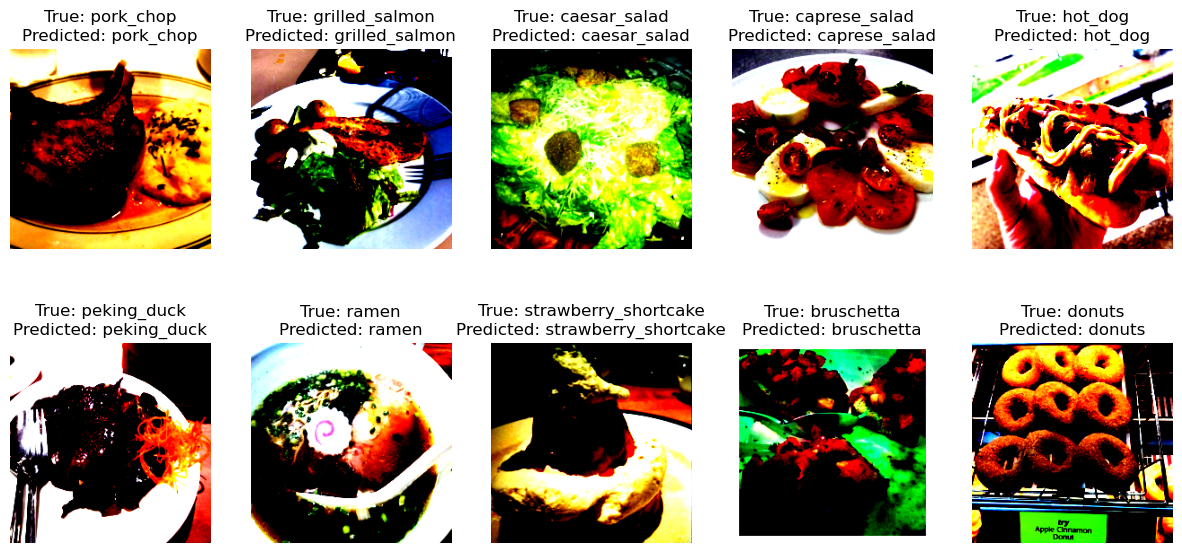

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Incorrectly Classified Examples:


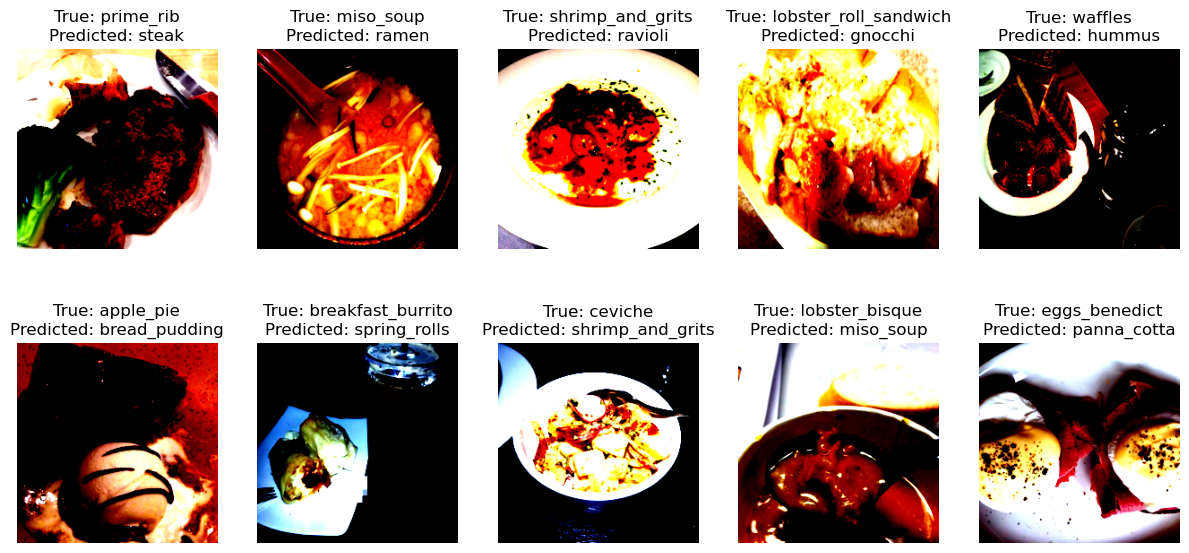

In [38]:
model.eval()
correctly_classified = []
incorrectly_classified = []

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing', unit='batch'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        inputs_cpu = inputs.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        for i in range(len(predicted_cpu)):
            image = np.transpose(inputs_cpu[i], (1, 2, 0))
            true_label = encoder.get_label(labels_cpu[i])
            predicted_label = encoder.get_label(predicted_cpu[i])

            if predicted_cpu[i] == labels_cpu[i]:
                correctly_classified.append((image, true_label, predicted_label))
            else:
                incorrectly_classified.append((image, true_label, predicted_label))

print("Correctly Classified Examples:")
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, (image, true_label, predicted_label) in enumerate(correctly_classified[:10]):
    axes[i // 5, i % 5].imshow(image)
    axes[i // 5, i % 5].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i // 5, i % 5].axis('off')

plt.show()

print("Incorrectly Classified Examples:")
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, (image, true_label, predicted_label) in enumerate(incorrectly_classified[:10]):
    axes[i // 5, i % 5].imshow(image)
    axes[i // 5, i % 5].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i // 5, i % 5].axis('off')

plt.show()


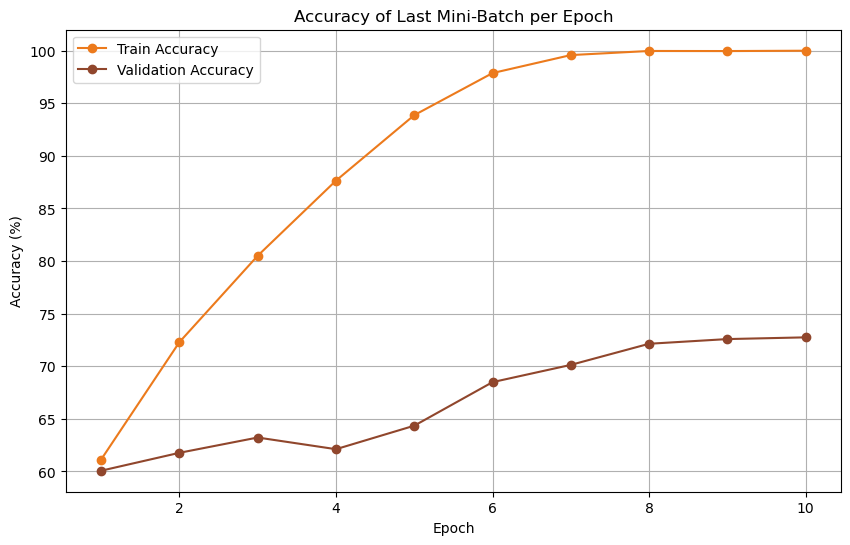

In [32]:
last_minibatch_train = results_df[results_df['Phase'] == 'Train'].groupby('Epoch').tail(1)
last_minibatch_val = results_df[results_df['Phase'] == 'Validation'].groupby('Epoch').tail(1)

# Set the colors
train_color = '#ec7a1c'
val_color = '#90462c'

plt.figure(figsize=(10, 6))
plt.plot(last_minibatch_train['Epoch'], last_minibatch_train['Accuracy'], label='Train Accuracy', marker='o', color=train_color)
plt.plot(last_minibatch_val['Epoch'], last_minibatch_val['Accuracy'], label='Validation Accuracy', marker='o', color=val_color)
plt.title('Accuracy of Last Mini-Batch per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

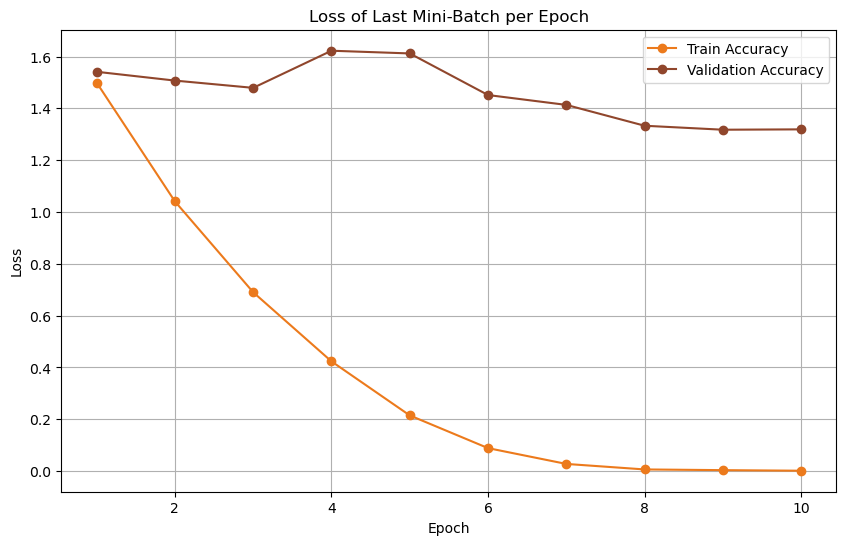

In [33]:
last_minibatch_train = results_df[results_df['Phase'] == 'Train'].groupby('Epoch').tail(1)
last_minibatch_val = results_df[results_df['Phase'] == 'Validation'].groupby('Epoch').tail(1)

# Set the colors
train_color = '#ec7a1c'
val_color = '#90462c'

plt.figure(figsize=(10, 6))
plt.plot(last_minibatch_train['Epoch'], last_minibatch_train['Loss'], label='Train Accuracy', marker='o', color=train_color)
plt.plot(last_minibatch_val['Epoch'], last_minibatch_val['Loss'], label='Validation Accuracy', marker='o', color=val_color)
plt.title('Loss of Last Mini-Batch per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing', unit='batch'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)

confusion_matrix_df = pd.DataFrame(cm, index=classes, columns=classes)

confusion_matrix_df['Correctly Classified'] = np.diag(cm)
confusion_matrix_df['Incorrectly Classified'] = 250 - np.diag(cm)
confusion_matrix_df.to_csv('confusion_matrix_with_counts.csv')
confusion_matrix_df['% Correct Classification'] = (confusion_matrix_df['Correctly Classified'] / 250) * 100
confusion_matrix_df.to_csv('confusion_matrix_with_percentages.csv')
confusion_matrix_df_sorted = confusion_matrix_df.sort_values(by='% Correct Classification', ascending=False)
confusion_matrix_df_sorted

Testing: 100%|████████████████████████████████████████████████████████████████████| 198/198 [02:49<00:00,  1.17batch/s]


,apple_pie,baby_back_ribs,baklava,beef_carpaccio,beef_tartare,beet_salad,beignets,bibimbap,bread_pudding,breakfast_burrito,...,strawberry_shortcake,sushi,tacos,takoyaki,tiramisu,tuna_tartare,waffles,Correctly Classified,Incorrectly Classified,% Correct Classification
apple_pie,246,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,246,4,98.4
pad_thai,0,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,235,15,94.0
breakfast_burrito,0,0,0,0,0,0,0,0,0,231,...,0,0,0,0,0,3,0,231,19,92.4
chocolate_cake,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,231,19,92.4
churros,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,230,20,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gnocchi,0,0,2,0,0,0,0,23,0,0,...,1,0,0,3,0,2,2,139,111,55.6
escargots,0,0,3,0,0,0,1,0,0,1,...,2,4,0,0,1,5,1,139,111,55.6
onion_rings,0,0,0,1,2,1,0,0,0,0,...,2,1,0,0,0,0,0,138,112,55.2
garlic_bread,1,0,1,0,0,0,0,9,0,0,...,1,0,1,0,1,1,0,132,118,52.8


### Results of running the model at different amounts of training data

We wanted to understand the impact of the size of training data in modeling. Generally, this is becomes a question in every real world setting --> Would more data improve our model?

We performed this test by running the six Resnet34 model with different amounts of traning data: 10%, 25%, 50%, 75%, 90%, 100%

From the results we can see that there is a possibility of improving the accuracy by accquiring more data and at the same time a more complex model could do better with the current amount of data. So there is a question of what is more affordable? --> What is more costly: Cost of data vs Cost of complexity

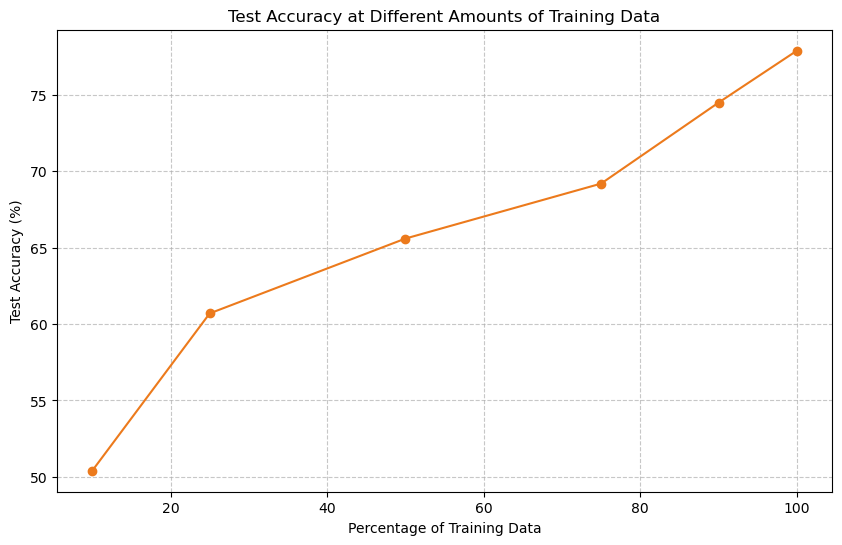

In [7]:
# Results from the six different resnet 34 models (Weights and results available on GitHub for these models)

plot_df = pd.read_csv(r"C:\Users\rsk29\Documents\UT\Fall\AML\Final Project\Varying Training Data\varying_training_data_results.csv")

plt.figure(figsize=(10, 6))
plt.plot(plot_df.training_data_pct, plot_df.test_Accuracy, marker='o', color='#ec7a1c', linestyle='-')
plt.title('Test Accuracy at Different Amounts of Training Data')
plt.xlabel('Percentage of Training Data')
plt.ylabel('Test Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
